<a href="https://colab.research.google.com/github/surendar-283/DA6401-Assignment-1/blob/main/DL_Assignmnet_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

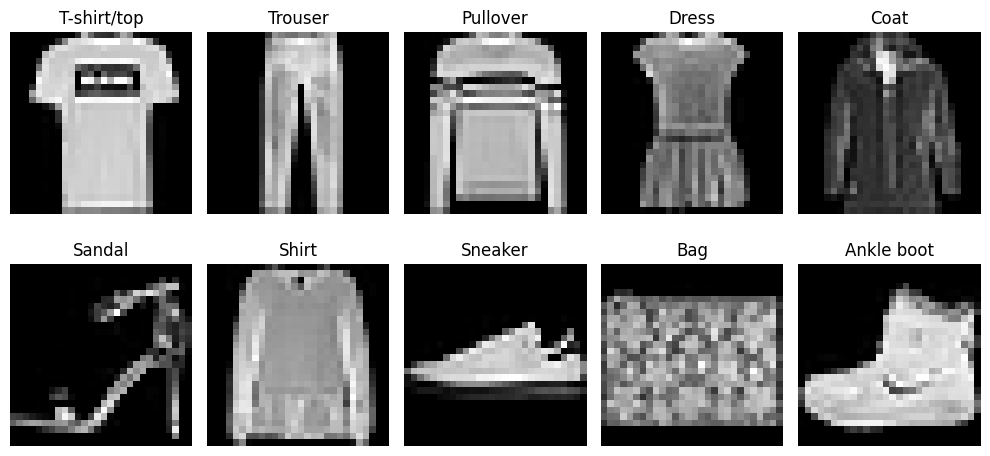

In [ ]:
#Q1
import numpy as np
import matplotlib.pyplot as plt
import wandb
from keras.datasets import fashion_mnist

wandb.init(project="DA6401_A1", name="Q1", mode="online")
wandb_images = []
(xtr,ytr),(xts,yts) = fashion_mnist.load_data()
l = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
f,a = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    img = xtr[ytr==i][0]
    a[i//5,i%5].imshow(img, cmap='gray')
    a[i//5,i%5].set_title(l[i])
    a[i//5,i%5].axis('off')
    wandb_images.append(wandb.Image(img, caption=l[i]))
plt.tight_layout()
plt.show()
wandb.log({"Q1": wandb_images})
wandb.finish()

In [ ]:
#Q2 to Q6
import numpy as np
import wandb
import pandas as pd
from keras.datasets import fashion_mnist

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

def sigmoid_derivative(x):
    return x * (1 - x)

def tanh_derivative(x):
    return 1 - np.power(x, 2)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def initialize_parameters(layer_sizes, init_method="random", weight_decay=0):
    np.random.seed(1)
    p = []

    for i in range(len(layer_sizes) - 1):
        if init_method == "random":
            W = np.random.uniform(-0.1, 0.1, (layer_sizes[i], layer_sizes[i+1]))
        elif init_method == "xavier":
            W = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / (layer_sizes[i] + layer_sizes[i+1]))

        b = np.zeros((1, layer_sizes[i+1]))
        p.append((W, b))

    return p

def forward(X, p, activation="sigmoid"):
    a = {0: X}
    A = X

    act_func = sigmoid
    if activation == "tanh":
        act_func = tanh
    elif activation == "relu":
        act_func = relu

    for i, (W, b) in enumerate(p[:-1]):
        Z = np.dot(A, W) + b
        A = act_func(Z)
        a[i+1] = A

    W_out, b_out = p[-1]
    Z_out = np.dot(A, W_out) + b_out
    A_out = softmax(Z_out)

    a[len(p)] = A_out
    return A_out, a

def backward(X, Y, p, a, activation="sigmoid", wd=0):
    m = X.shape[0]
    gradients = {}

    act_deriv = sigmoid_derivative
    if activation == "tanh":
        act_deriv = tanh_derivative
    elif activation == "relu":
        act_deriv = relu_derivative

    A_out = a[len(p)]
    dZ_out = A_out.copy()
    dZ_out[np.arange(m), Y] -= 1
    dZ_out /= m

    W_out = p[-1][0]
    reg_term = 0
    if wd > 0:
        reg_term = wd * W_out

    gradients[len(p)] = (np.dot(a[len(p)-1].T, dZ_out) + reg_term,
                              np.sum(dZ_out, axis=0, keepdims=True))

    dA = np.dot(dZ_out, p[-1][0].T)

    for i in reversed(range(len(p) - 1)):
        if activation == "relu":
            if i == 0:
                prev_A = a[i]
            else:
                prev_A = a[i]

            W, b = p[i]
            Z = np.dot(prev_A, W) + b
            dZ = dA * relu_derivative(Z)
        else:
            dZ = dA * act_deriv(a[i+1])

        W = p[i][0]
        reg_term = 0
        if wd > 0:
            reg_term = wd * W

        gradients[i+1] = (np.dot(a[i].T, dZ) + reg_term,
                     np.sum(dZ, axis=0, keepdims=True))

        dA = np.dot(dZ, p[i][0].T)

    return gradients

def compute_loss(Y_pred, Y_true, p=None, wd=0):
    cross_entropy = -np.mean(np.log(Y_pred[np.arange(Y_true.shape[0]), Y_true] + 1e-9))

    reg_term = 0
    if wd > 0 and p is not None:
        for W, _ in p:
            reg_term += 0.5 * wd * np.sum(np.square(W))

    return cross_entropy + reg_term

def update_parameters(p, g, lr):
    for i in range(len(p)):
        W, b = p[i]
        dW, db = g[i+1]
        W = W - lr * dW
        b = b - lr * db
        p[i] = (W, b)
    return p

def create_train_val_split(X, y, val_ratio=0.1, random_seed=1):
    np.random.seed(random_seed)
    indices = np.random.permutation(len(X))
    val_size = int(len(X) * val_ratio)
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]

    X_train = X[train_indices]
    y_train = y[train_indices]
    X_val = X[val_indices]
    y_val = y[val_indices]

    return X_train, X_val, y_train, y_val

def train_model():
    with wandb.init() as run:
        config = wandb.config

        run.name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_opt_{config.optimizer}_ac_{config.activation}_wd_{config.weight_decay}"

        (X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

        X_train_full = X_train_full.reshape(-1, 28 * 28) / 255.0
        X_test = X_test.reshape(-1, 28 * 28) / 255.0

        X_train, X_val, y_train, y_val = create_train_val_split(
            X_train_full, y_train_full, val_ratio=0.1, random_seed=42
        )

        input_size = X_train.shape[1]
        output_size = 10

        hidden_layers = [config.hidden_size] * config.num_hidden_layers
        layer_sizes = [input_size] + hidden_layers + [output_size]

        print(f"Network architecture: {layer_sizes}")

        if config.weight_init == "xavier":
            parameters = initialize_parameters(layer_sizes, init_method="xavier")
        else:
            parameters = initialize_parameters(layer_sizes, init_method="random")

        optimizer_type = config.optimizer
        weight_decay = config.weight_decay
        batch_size = config.batch_size

        if optimizer_type == "sgd":
            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                xs = X_train[indices]
                ys = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    X_batch = xs[i:i+batch_size]
                    y_batch = ys[i:i+batch_size]

                    y_pred, layer_activations = forward(X_batch, parameters, activation=config.activation)

                    gradients = backward(X_batch, y_batch, parameters, layer_activations,activation=config.activation, wd=weight_decay)

                    parameters = update_parameters(parameters, gradients, config.learning_rate)

                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer_type == "momentum":
            momentum_values = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta = 0.9

            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                xs = X_train[indices]
                ys = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    X_batch = xs[i:i+batch_size]
                    y_batch = ys[i:i+batch_size]

                    y_pred, layer_activations = forward(X_batch, parameters, activation=config.activation)

                    gradients = backward(X_batch, y_batch, parameters, layer_activations,
                                    activation=config.activation, wd=weight_decay)

                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = gradients[j+1]
                        vW, vb = momentum_values[j]

                        vW = beta * vW - config.learning_rate * dW
                        vb = beta * vb - config.learning_rate * db

                        W = W + vW
                        b = b + vb

                        parameters[j] = (W, b)
                        momentum_values[j] = (vW, vb)

                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer_type == "nesterov":
            momentum_values = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta = 0.9

            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                xs = X_train[indices]
                ys = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    X_batch = xs[i:i+batch_size]
                    y_batch = ys[i:i+batch_size]

                    lookahead_parameters = []
                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        vW, vb = momentum_values[j]
                        lookahead_W = W + beta * vW
                        lookahead_b = b + beta * vb
                        lookahead_parameters.append((lookahead_W, lookahead_b))

                    y_pred, layer_activations = forward(X_batch, lookahead_parameters, activation=config.activation)

                    gradients = backward(X_batch, y_batch, lookahead_parameters, layer_activations,
                                    activation=config.activation, wd=weight_decay)

                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = gradients[j+1]
                        vW, vb = momentum_values[j]

                        vW = beta * vW - config.learning_rate * dW
                        vb = beta * vb - config.learning_rate * db

                        W = W + vW
                        b = b + vb

                        parameters[j] = (W, b)
                        momentum_values[j] = (vW, vb)

                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer_type == "rmsprop":
            squared_grads = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta = 0.9
            epsilon = 1e-8

            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                xs = X_train[indices]
                ys = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    X_batch = xs[i:i+batch_size]
                    y_batch = ys[i:i+batch_size]

                    y_pred, layer_activations = forward(X_batch, parameters, activation=config.activation)

                    gradients = backward(X_batch, y_batch, parameters, layer_activations,
                                    activation=config.activation, wd=weight_decay)

                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = gradients[j+1]
                        sW, sb = squared_grads[j]

                        sW = beta * sW + (1 - beta) * (dW ** 2)
                        sb = beta * sb + (1 - beta) * (db ** 2)

                        W = W - config.learning_rate * dW / (np.sqrt(sW) + epsilon)
                        b = b - config.learning_rate * db / (np.sqrt(sb) + epsilon)

                        parameters[j] = (W, b)
                        squared_grads[j] = (sW, sb)

                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer_type == "adam":
            first_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            second_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta1 = 0.9
            beta2 = 0.999
            epsilon = 1e-8
            t = 0

            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                xs = X_train[indices]
                ys = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    t += 1
                    X_batch = xs[i:i+batch_size]
                    y_batch = ys[i:i+batch_size]

                    y_pred, layer_activations = forward(X_batch, parameters, activation=config.activation)

                    gradients = backward(X_batch, y_batch, parameters, layer_activations,
                                    activation=config.activation, wd=weight_decay)

                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = gradients[j+1]
                        mW, mb = first_moment[j]
                        vW, vb = second_moment[j]

                        mW = beta1 * mW + (1 - beta1) * dW
                        mb = beta1 * mb + (1 - beta1) * db

                        vW = beta2 * vW + (1 - beta2) * (dW ** 2)
                        vb = beta2 * vb + (1 - beta2) * (db ** 2)

                        mW_hat = mW / (1 - beta1**t)
                        mb_hat = mb / (1 - beta1**t)

                        vW_hat = vW / (1 - beta2**t)
                        vb_hat = vb / (1 - beta2**t)

                        W = W - config.learning_rate * mW_hat / (np.sqrt(vW_hat) + epsilon)
                        b = b - config.learning_rate * mb_hat / (np.sqrt(vb_hat) + epsilon)

                        parameters[j] = (W, b)
                        first_moment[j] = (mW, mb)
                        second_moment[j] = (vW, vb)

                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer_type == "nadam":
            first_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            second_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta1 = 0.9
            beta2 = 0.999
            epsilon = 1e-8
            t = 0

            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                xs = X_train[indices]
                ys = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    t += 1
                    X_batch = xs[i:i+batch_size]
                    y_batch = ys[i:i+batch_size]

                    y_pred, layer_activations = forward(X_batch, parameters, activation=config.activation)

                    gradients = backward(X_batch, y_batch, parameters, layer_activations,
                                    activation=config.activation, wd=weight_decay)

                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = gradients[j+1]
                        mW, mb = first_moment[j]
                        vW, vb = second_moment[j]

                        mW = beta1 * mW + (1 - beta1) * dW
                        mb = beta1 * mb + (1 - beta1) * db

                        vW = beta2 * vW + (1 - beta2) * (dW ** 2)
                        vb = beta2 * vb + (1 - beta2) * (db ** 2)

                        mW_hat = mW / (1 - beta1**t)
                        mb_hat = mb / (1 - beta1**t)

                        vW_hat = vW / (1 - beta2**t)
                        vb_hat = vb / (1 - beta2**t)

                        mW_nesterov = beta1 * mW_hat + (1 - beta1) * dW / (1 - beta1**t)
                        mb_nesterov = beta1 * mb_hat + (1 - beta1) * db / (1 - beta1**t)

                        W = W - config.learning_rate * mW_nesterov / (np.sqrt(vW_hat) + epsilon)
                        b = b - config.learning_rate * mb_nesterov / (np.sqrt(vb_hat) + epsilon)

                        parameters[j] = (W, b)
                        first_moment[j] = (mW, mb)
                        second_moment[j] = (vW, vb)

                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        test_pred, _ = forward(X_test, parameters, activation=config.activation)
        test_loss = compute_loss(test_pred, y_test, parameters, weight_decay)
        test_acc = np.mean(np.argmax(test_pred, axis=1) == y_test)

        wandb.log({
            "test_loss": test_loss,
            "test_accuracy": test_acc
        })

        print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

        return parameters

def setup_wandb_sweep():
    sweep_config = {
        'method': 'bayes',
        'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
        'parameters': {
            'epochs': {'values': [5, 10]},
            'num_hidden_layers': {'values': [3, 4, 5]},
            'hidden_size': {'values': [32, 64, 128]},
            'weight_decay': {'values': [0, 0.0005, 0.5]},
            'learning_rate': {'values': [1e-3, 1e-4]},
            'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
            'batch_size': {'values': [16, 32, 64]},
            'weight_init': {'values': ['random', 'xavier']},
            'activation': {'values': ['sigmoid', 'tanh', 'relu']}
        }
    }

    return wandb.sweep(sweep_config, project="DA6401-A1")

wandb.login()
sweep_id = setup_wandb_sweep()
wandb.agent(sweep_id, train_model, count=20)

Create sweep with ID: ozdk80lj
Sweep URL: https://wandb.ai/surendarmohan283-indian-institute-of-technology-madras/DA6401_A1/sweeps/ozdk80lj


wandb: Agent Starting Run: ml4fygbz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Network architecture: [784, 128, 128, 128, 128, 128, 10]
Epoch 1/5, Train Loss: 1.3315, Val Loss: 0.8240, Val Acc: 0.6403
Epoch 2/5, Train Loss: 0.7207, Val Loss: 0.6636, Val Acc: 0.7317
Epoch 3/5, Train Loss: 0.5721, Val Loss: 0.5461, Val Acc: 0.8018
Epoch 4/5, Train Loss: 0.4838, Val Loss: 0.5151, Val Acc: 0.7970
Epoch 5/5, Train Loss: 0.4374, Val Loss: 0.4553, Val Acc: 0.8250
Final Test Loss: 0.4782, Test Accuracy: 0.8184


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▄▇▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,0.8184
test_loss,0.47817
train_accuracy,0.84154


wandb: Agent Starting Run: gj9r36wx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 32, 32, 32, 32, 10]
Epoch 1/5, Train Loss: 1.8154, Val Loss: 1.4498, Val Acc: 0.6203
Epoch 2/5, Train Loss: 1.2438, Val Loss: 1.1001, Val Acc: 0.6990
Epoch 3/5, Train Loss: 0.9869, Val Loss: 0.9114, Val Acc: 0.7245
Epoch 4/5, Train Loss: 0.8409, Val Loss: 0.7992, Val Acc: 0.7383
Epoch 5/5, Train Loss: 0.7525, Val Loss: 0.7284, Val Acc: 0.7538
Final Test Loss: 0.7400, Test Accuracy: 0.7514


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▇▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,0.7514
test_loss,0.74002
train_accuracy,0.76191


wandb: Agent Starting Run: i3c2mo92 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Network architecture: [784, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.9413, Val Loss: 0.5481, Val Acc: 0.7878
Epoch 2/10, Train Loss: 0.4894, Val Loss: 0.4462, Val Acc: 0.8367
Epoch 3/10, Train Loss: 0.4282, Val Loss: 0.3937, Val Acc: 0.8587
Epoch 4/10, Train Loss: 0.3959, Val Loss: 0.3711, Val Acc: 0.8682
Epoch 5/10, Train Loss: 0.3717, Val Loss: 0.3598, Val Acc: 0.8725
Epoch 6/10, Train Loss: 0.3510, Val Loss: 0.3743, Val Acc: 0.8627
Epoch 7/10, Train Loss: 0.3373, Val Loss: 0.3400, Val Acc: 0.8788
Epoch 8/10, Train Loss: 0.3248, Val Loss: 0.3410, Val Acc: 0.8808
Epoch 9/10, Train Loss: 0.3153, Val Loss: 0.3908, Val Acc: 0.8612
Epoch 10/10, Train Loss: 0.3055, Val Loss: 0.3853, Val Acc: 0.8607
Final Test Loss: 0.4238, Test Accuracy: 0.8494


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▆▇▇▇██▇▇
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇██▇▆
val_loss,█▅▃▂▂▂▁▁▃▃
epoch,10
test_accuracy,0.8494
test_loss,0.42382
train_accuracy,0.87541


wandb: Agent Starting Run: qithm3l7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Network architecture: [784, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.8718, Val Loss: 0.5233, Val Acc: 0.8127
Epoch 2/10, Train Loss: 0.4712, Val Loss: 0.4326, Val Acc: 0.8405
Epoch 3/10, Train Loss: 0.4186, Val Loss: 0.4031, Val Acc: 0.8527
Epoch 4/10, Train Loss: 0.3921, Val Loss: 0.3873, Val Acc: 0.8587
Epoch 5/10, Train Loss: 0.3738, Val Loss: 0.3763, Val Acc: 0.8615
Epoch 6/10, Train Loss: 0.3603, Val Loss: 0.3576, Val Acc: 0.8682
Epoch 7/10, Train Loss: 0.3487, Val Loss: 0.3520, Val Acc: 0.8705
Epoch 8/10, Train Loss: 0.3384, Val Loss: 0.3462, Val Acc: 0.8755
Epoch 9/10, Train Loss: 0.3297, Val Loss: 0.3416, Val Acc: 0.8787
Epoch 10/10, Train Loss: 0.3224, Val Loss: 0.3414, Val Acc: 0.8775
Final Test Loss: 0.3725, Test Accuracy: 0.8657


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.8657
test_loss,0.3725
train_accuracy,0.88735


wandb: Agent Starting Run: 47lbgjln with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.8917, Val Loss: 0.5705, Val Acc: 0.7950
Epoch 2/10, Train Loss: 0.5111, Val Loss: 0.4891, Val Acc: 0.8277
Epoch 3/10, Train Loss: 0.4546, Val Loss: 0.4512, Val Acc: 0.8382
Epoch 4/10, Train Loss: 0.4254, Val Loss: 0.4190, Val Acc: 0.8473
Epoch 5/10, Train Loss: 0.4046, Val Loss: 0.4070, Val Acc: 0.8540
Epoch 6/10, Train Loss: 0.3883, Val Loss: 0.3880, Val Acc: 0.8593
Epoch 7/10, Train Loss: 0.3750, Val Loss: 0.3878, Val Acc: 0.8610
Epoch 8/10, Train Loss: 0.3631, Val Loss: 0.3759, Val Acc: 0.8642
Epoch 9/10, Train Loss: 0.3529, Val Loss: 0.3621, Val Acc: 0.8687
Epoch 10/10, Train Loss: 0.3443, Val Loss: 0.3679, Val Acc: 0.8668
Final Test Loss: 0.3940, Test Accuracy: 0.8582


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,0.8582
test_loss,0.39398
train_accuracy,0.87824


wandb: Agent Starting Run: spg4rq0w with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Network architecture: [784, 64, 64, 64, 10]
Epoch 1/10, Train Loss: 19.1106, Val Loss: 4.8820, Val Acc: 0.1045
Epoch 2/10, Train Loss: 2.9604, Val Loss: 2.3356, Val Acc: 0.0917
Epoch 3/10, Train Loss: 2.3083, Val Loss: 2.3027, Val Acc: 0.0917
Epoch 4/10, Train Loss: 2.3026, Val Loss: 2.3027, Val Acc: 0.0917
Epoch 5/10, Train Loss: 2.3026, Val Loss: 2.3027, Val Acc: 0.0917
Epoch 6/10, Train Loss: 2.3026, Val Loss: 2.3027, Val Acc: 0.0917
Epoch 7/10, Train Loss: 2.3026, Val Loss: 2.3027, Val Acc: 0.0917
Epoch 8/10, Train Loss: 2.3026, Val Loss: 2.3027, Val Acc: 0.0917
Epoch 9/10, Train Loss: 2.3026, Val Loss: 2.3027, Val Acc: 0.0917
Epoch 10/10, Train Loss: 2.3026, Val Loss: 2.3027, Val Acc: 0.0917
Final Test Loss: 2.3026, Test Accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁█████████
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,█▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.1
test_loss,2.30259
train_accuracy,0.10093


wandb: Agent Starting Run: 2ceahs4c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 1.8845, Val Loss: 1.3743, Val Acc: 0.4193
Epoch 2/10, Train Loss: 1.1928, Val Loss: 1.0942, Val Acc: 0.5835
Epoch 3/10, Train Loss: 0.9985, Val Loss: 0.8979, Val Acc: 0.6883
Epoch 4/10, Train Loss: 0.8015, Val Loss: 0.7371, Val Acc: 0.7468
Epoch 5/10, Train Loss: 0.6880, Val Loss: 0.6588, Val Acc: 0.7633
Epoch 6/10, Train Loss: 0.6277, Val Loss: 0.6107, Val Acc: 0.7723
Epoch 7/10, Train Loss: 0.5861, Val Loss: 0.5753, Val Acc: 0.7830
Epoch 8/10, Train Loss: 0.5557, Val Loss: 0.5497, Val Acc: 0.7902
Epoch 9/10, Train Loss: 0.5321, Val Loss: 0.5258, Val Acc: 0.7958
Epoch 10/10, Train Loss: 0.5117, Val Loss: 0.5107, Val Acc: 0.7978
Final Test Loss: 0.5318, Test Accuracy: 0.8016


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8016
test_loss,0.53183
train_accuracy,0.81143


wandb: Agent Starting Run: yea4rz7b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 2.2253, Val Loss: 2.1426, Val Acc: 0.5182
Epoch 2/10, Train Loss: 2.0100, Val Loss: 1.8498, Val Acc: 0.5292
Epoch 3/10, Train Loss: 1.6711, Val Loss: 1.5221, Val Acc: 0.5332
Epoch 4/10, Train Loss: 1.4080, Val Loss: 1.3226, Val Acc: 0.5585
Epoch 5/10, Train Loss: 1.2475, Val Loss: 1.1951, Val Acc: 0.5740
Epoch 6/10, Train Loss: 1.1385, Val Loss: 1.1035, Val Acc: 0.5910
Epoch 7/10, Train Loss: 1.0569, Val Loss: 1.0323, Val Acc: 0.6097
Epoch 8/10, Train Loss: 0.9921, Val Loss: 0.9750, Val Acc: 0.6247
Epoch 9/10, Train Loss: 0.9388, Val Loss: 0.9261, Val Acc: 0.6408
Epoch 10/10, Train Loss: 0.8937, Val Loss: 0.8849, Val Acc: 0.6525
Final Test Loss: 0.8922, Test Accuracy: 0.6543


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▁▃▄▅▆▆▇█
train_loss,█▇▅▄▃▂▂▂▁▁
val_accuracy,▁▂▂▃▄▅▆▇▇█
val_loss,█▆▅▃▃▂▂▂▁▁
epoch,10
test_accuracy,0.6543
test_loss,0.89216
train_accuracy,0.66304


wandb: Agent Starting Run: lq9aaal7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 1.8845, Val Loss: 1.3743, Val Acc: 0.4193
Epoch 2/10, Train Loss: 1.1928, Val Loss: 1.0942, Val Acc: 0.5835
Epoch 3/10, Train Loss: 0.9985, Val Loss: 0.8979, Val Acc: 0.6883
Epoch 4/10, Train Loss: 0.8015, Val Loss: 0.7371, Val Acc: 0.7468
Epoch 5/10, Train Loss: 0.6880, Val Loss: 0.6588, Val Acc: 0.7633
Epoch 6/10, Train Loss: 0.6277, Val Loss: 0.6107, Val Acc: 0.7723
Epoch 7/10, Train Loss: 0.5861, Val Loss: 0.5753, Val Acc: 0.7830
Epoch 8/10, Train Loss: 0.5557, Val Loss: 0.5497, Val Acc: 0.7902
Epoch 9/10, Train Loss: 0.5321, Val Loss: 0.5258, Val Acc: 0.7958
Epoch 10/10, Train Loss: 0.5117, Val Loss: 0.5107, Val Acc: 0.7978
Final Test Loss: 0.5318, Test Accuracy: 0.8016


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8016
test_loss,0.53183
train_accuracy,0.81143


wandb: Agent Starting Run: mbw96b8e with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Network architecture: [784, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 1.9354, Val Loss: 1.5912, Val Acc: 0.3928
Epoch 2/10, Train Loss: 1.3826, Val Loss: 1.2535, Val Acc: 0.5453
Epoch 3/10, Train Loss: 1.1665, Val Loss: 1.0872, Val Acc: 0.6418
Epoch 4/10, Train Loss: 0.9669, Val Loss: 0.8480, Val Acc: 0.6987
Epoch 5/10, Train Loss: 0.7532, Val Loss: 0.6963, Val Acc: 0.7363
Epoch 6/10, Train Loss: 0.6510, Val Loss: 0.6216, Val Acc: 0.7620
Epoch 7/10, Train Loss: 0.5944, Val Loss: 0.5752, Val Acc: 0.7798
Epoch 8/10, Train Loss: 0.5538, Val Loss: 0.5374, Val Acc: 0.7943
Epoch 9/10, Train Loss: 0.5215, Val Loss: 0.5098, Val Acc: 0.8123
Epoch 10/10, Train Loss: 0.4962, Val Loss: 0.4873, Val Acc: 0.8213
Final Test Loss: 0.5134, Test Accuracy: 0.8194


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▅▆▇▇▇███
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▆▅▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8194
test_loss,0.51337
train_accuracy,0.82974


wandb: Agent Starting Run: e5feq22r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Network architecture: [784, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 1.9593, Val Loss: 1.6074, Val Acc: 0.3980
Epoch 2/10, Train Loss: 1.3926, Val Loss: 1.2557, Val Acc: 0.5403
Epoch 3/10, Train Loss: 1.1676, Val Loss: 1.0881, Val Acc: 0.6307
Epoch 4/10, Train Loss: 0.9930, Val Loss: 0.8950, Val Acc: 0.6800
Epoch 5/10, Train Loss: 0.8007, Val Loss: 0.7362, Val Acc: 0.7242
Epoch 6/10, Train Loss: 0.6918, Val Loss: 0.6657, Val Acc: 0.7422
Epoch 7/10, Train Loss: 0.6364, Val Loss: 0.6166, Val Acc: 0.7610
Epoch 8/10, Train Loss: 0.5952, Val Loss: 0.5780, Val Acc: 0.7757
Epoch 9/10, Train Loss: 0.5608, Val Loss: 0.5506, Val Acc: 0.7850
Epoch 10/10, Train Loss: 0.5333, Val Loss: 0.5220, Val Acc: 0.8008
Final Test Loss: 0.5434, Test Accuracy: 0.8007


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▆▅▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8007
test_loss,0.54338
train_accuracy,0.80967


wandb: Agent Starting Run: w6mi4j6s with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.7470, Val Loss: 0.4919, Val Acc: 0.8257
Epoch 2/10, Train Loss: 0.4491, Val Loss: 0.4296, Val Acc: 0.8445
Epoch 3/10, Train Loss: 0.4064, Val Loss: 0.4153, Val Acc: 0.8492
Epoch 4/10, Train Loss: 0.3811, Val Loss: 0.3775, Val Acc: 0.8613
Epoch 5/10, Train Loss: 0.3623, Val Loss: 0.3822, Val Acc: 0.8630
Epoch 6/10, Train Loss: 0.3480, Val Loss: 0.3618, Val Acc: 0.8687
Epoch 7/10, Train Loss: 0.3338, Val Loss: 0.3576, Val Acc: 0.8742
Epoch 8/10, Train Loss: 0.3235, Val Loss: 0.3572, Val Acc: 0.8730
Epoch 9/10, Train Loss: 0.3145, Val Loss: 0.3401, Val Acc: 0.8790
Epoch 10/10, Train Loss: 0.3036, Val Loss: 0.3416, Val Acc: 0.8790
Final Test Loss: 0.3721, Test Accuracy: 0.8670


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▄▆▆▇▇▇██
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,0.867
test_loss,0.37207
train_accuracy,0.89359


wandb: Agent Starting Run: py9bu8o0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.7616, Val Loss: 0.5032, Val Acc: 0.8228
Epoch 2/10, Train Loss: 0.4539, Val Loss: 0.4295, Val Acc: 0.8465
Epoch 3/10, Train Loss: 0.4100, Val Loss: 0.4127, Val Acc: 0.8503
Epoch 4/10, Train Loss: 0.3846, Val Loss: 0.3907, Val Acc: 0.8582
Epoch 5/10, Train Loss: 0.3661, Val Loss: 0.4018, Val Acc: 0.8573
Epoch 6/10, Train Loss: 0.3505, Val Loss: 0.3620, Val Acc: 0.8717
Epoch 7/10, Train Loss: 0.3355, Val Loss: 0.3543, Val Acc: 0.8763
Epoch 8/10, Train Loss: 0.3254, Val Loss: 0.3565, Val Acc: 0.8752
Epoch 9/10, Train Loss: 0.3167, Val Loss: 0.3356, Val Acc: 0.8830
Epoch 10/10, Train Loss: 0.3038, Val Loss: 0.3447, Val Acc: 0.8780
Final Test Loss: 0.3713, Test Accuracy: 0.8668


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▄▅▅▇▇▇██
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▄▅▅▇▇▇█▇
val_loss,█▅▄▃▄▂▂▂▁▁
epoch,10
test_accuracy,0.8668
test_loss,0.37127
train_accuracy,0.89078


wandb: Agent Starting Run: weaj15hm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.4971, Val Loss: 0.4220, Val Acc: 0.8438
Epoch 2/10, Train Loss: 0.3636, Val Loss: 0.3494, Val Acc: 0.8698
Epoch 3/10, Train Loss: 0.3274, Val Loss: 0.3524, Val Acc: 0.8703
Epoch 4/10, Train Loss: 0.3051, Val Loss: 0.3412, Val Acc: 0.8798
Epoch 5/10, Train Loss: 0.2877, Val Loss: 0.3510, Val Acc: 0.8740
Epoch 6/10, Train Loss: 0.2751, Val Loss: 0.3266, Val Acc: 0.8845
Epoch 7/10, Train Loss: 0.2606, Val Loss: 0.3282, Val Acc: 0.8823
Epoch 8/10, Train Loss: 0.2507, Val Loss: 0.3142, Val Acc: 0.8890
Epoch 9/10, Train Loss: 0.2410, Val Loss: 0.3201, Val Acc: 0.8908
Epoch 10/10, Train Loss: 0.2321, Val Loss: 0.3351, Val Acc: 0.8798
Final Test Loss: 0.3463, Test Accuracy: 0.8773


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▄▄▃▂▂▂▁▁▁
val_accuracy,▁▅▅▆▅▇▇██▆
val_loss,█▃▃▃▃▂▂▁▁▂
epoch,10
test_accuracy,0.8773
test_loss,0.34634
train_accuracy,0.91448


wandb: Agent Starting Run: hyfywpde with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.7568, Val Loss: 0.5021, Val Acc: 0.8285
Epoch 2/10, Train Loss: 0.4557, Val Loss: 0.4356, Val Acc: 0.8442
Epoch 3/10, Train Loss: 0.4108, Val Loss: 0.4039, Val Acc: 0.8580
Epoch 4/10, Train Loss: 0.3850, Val Loss: 0.3914, Val Acc: 0.8628
Epoch 5/10, Train Loss: 0.3669, Val Loss: 0.3713, Val Acc: 0.8682
Epoch 6/10, Train Loss: 0.3520, Val Loss: 0.3681, Val Acc: 0.8652
Epoch 7/10, Train Loss: 0.3387, Val Loss: 0.3552, Val Acc: 0.8727
Epoch 8/10, Train Loss: 0.3273, Val Loss: 0.3443, Val Acc: 0.8775
Epoch 9/10, Train Loss: 0.3182, Val Loss: 0.3461, Val Acc: 0.8798
Epoch 10/10, Train Loss: 0.3097, Val Loss: 0.3369, Val Acc: 0.8828
Final Test Loss: 0.3610, Test Accuracy: 0.8727


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▄▅▆▆▇▇▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▃▅▅▆▆▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8727
test_loss,0.36096
train_accuracy,0.89507


wandb: Agent Starting Run: umfquh1t with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.4971, Val Loss: 0.4220, Val Acc: 0.8438
Epoch 2/10, Train Loss: 0.3636, Val Loss: 0.3494, Val Acc: 0.8698
Epoch 3/10, Train Loss: 0.3274, Val Loss: 0.3524, Val Acc: 0.8703
Epoch 4/10, Train Loss: 0.3051, Val Loss: 0.3412, Val Acc: 0.8798
Epoch 5/10, Train Loss: 0.2877, Val Loss: 0.3510, Val Acc: 0.8740
Epoch 6/10, Train Loss: 0.2751, Val Loss: 0.3266, Val Acc: 0.8845
Epoch 7/10, Train Loss: 0.2606, Val Loss: 0.3282, Val Acc: 0.8823
Epoch 8/10, Train Loss: 0.2507, Val Loss: 0.3142, Val Acc: 0.8890
Epoch 9/10, Train Loss: 0.2410, Val Loss: 0.3201, Val Acc: 0.8908
Epoch 10/10, Train Loss: 0.2321, Val Loss: 0.3351, Val Acc: 0.8798
Final Test Loss: 0.3463, Test Accuracy: 0.8773


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▄▄▃▂▂▂▁▁▁
val_accuracy,▁▅▅▆▅▇▇██▆
val_loss,█▃▃▃▃▂▂▁▁▂
epoch,10
test_accuracy,0.8773
test_loss,0.34634
train_accuracy,0.91448


wandb: Agent Starting Run: ia3obkdr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.6009, Val Loss: 0.4435, Val Acc: 0.8408
Epoch 2/10, Train Loss: 0.4158, Val Loss: 0.3964, Val Acc: 0.8527
Epoch 3/10, Train Loss: 0.3796, Val Loss: 0.3916, Val Acc: 0.8578
Epoch 4/10, Train Loss: 0.3577, Val Loss: 0.3555, Val Acc: 0.8657
Epoch 5/10, Train Loss: 0.3411, Val Loss: 0.3714, Val Acc: 0.8633
Epoch 6/10, Train Loss: 0.3279, Val Loss: 0.3413, Val Acc: 0.8745
Epoch 7/10, Train Loss: 0.3152, Val Loss: 0.3367, Val Acc: 0.8797
Epoch 8/10, Train Loss: 0.3062, Val Loss: 0.3360, Val Acc: 0.8787
Epoch 9/10, Train Loss: 0.2965, Val Loss: 0.3351, Val Acc: 0.8775
Epoch 10/10, Train Loss: 0.2877, Val Loss: 0.3178, Val Acc: 0.8837
Final Test Loss: 0.3502, Test Accuracy: 0.8749


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▃▅▅▆▇▇▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▄▅▅▇▇▇▇█
val_loss,█▅▅▃▄▂▂▂▂▁
epoch,10
test_accuracy,0.8749
test_loss,0.35022
train_accuracy,0.90026


wandb: Agent Starting Run: reoy4szk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.4873, Val Loss: 0.3994, Val Acc: 0.8515
Epoch 2/10, Train Loss: 0.3773, Val Loss: 0.3903, Val Acc: 0.8555
Epoch 3/10, Train Loss: 0.3470, Val Loss: 0.3697, Val Acc: 0.8630
Epoch 4/10, Train Loss: 0.3233, Val Loss: 0.3662, Val Acc: 0.8643
Epoch 5/10, Train Loss: 0.3053, Val Loss: 0.3435, Val Acc: 0.8738
Epoch 6/10, Train Loss: 0.2945, Val Loss: 0.3273, Val Acc: 0.8830
Epoch 7/10, Train Loss: 0.2835, Val Loss: 0.3379, Val Acc: 0.8790
Epoch 8/10, Train Loss: 0.2767, Val Loss: 0.3301, Val Acc: 0.8807
Epoch 9/10, Train Loss: 0.2641, Val Loss: 0.3375, Val Acc: 0.8758
Epoch 10/10, Train Loss: 0.2580, Val Loss: 0.3246, Val Acc: 0.8823
Final Test Loss: 0.3504, Test Accuracy: 0.8749


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▃▄▅▇▇▇▇█
train_loss,█▅▄▃▂▂▂▂▁▁
val_accuracy,▁▂▄▄▆█▇▇▆█
val_loss,█▇▅▅▃▁▂▂▂▁
epoch,10
test_accuracy,0.8749
test_loss,0.35042
train_accuracy,0.91239


wandb: Agent Starting Run: 74wddfaw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/5, Train Loss: 0.6009, Val Loss: 0.4435, Val Acc: 0.8408
Epoch 2/5, Train Loss: 0.4158, Val Loss: 0.3964, Val Acc: 0.8527
Epoch 3/5, Train Loss: 0.3796, Val Loss: 0.3916, Val Acc: 0.8578
Epoch 4/5, Train Loss: 0.3577, Val Loss: 0.3555, Val Acc: 0.8657
Epoch 5/5, Train Loss: 0.3411, Val Loss: 0.3714, Val Acc: 0.8633
Final Test Loss: 0.4017, Test Accuracy: 0.8539


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▅█▇
train_loss,█▃▂▁▁
val_accuracy,▁▄▆█▇
val_loss,█▄▄▁▂
epoch,5
test_accuracy,0.8539
test_loss,0.40174
train_accuracy,0.87398


wandb: Agent Starting Run: 16r1hoha with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 1.4510, Val Loss: 1.0453, Val Acc: 0.5960
Epoch 2/10, Train Loss: 0.8534, Val Loss: 0.7210, Val Acc: 0.7455
Epoch 3/10, Train Loss: 0.6495, Val Loss: 0.6133, Val Acc: 0.7682
Epoch 4/10, Train Loss: 0.5667, Val Loss: 0.5439, Val Acc: 0.7908
Epoch 5/10, Train Loss: 0.5217, Val Loss: 0.5205, Val Acc: 0.7970
Epoch 6/10, Train Loss: 0.4913, Val Loss: 0.4833, Val Acc: 0.8200
Epoch 7/10, Train Loss: 0.4645, Val Loss: 0.4563, Val Acc: 0.8378
Epoch 8/10, Train Loss: 0.4413, Val Loss: 0.4383, Val Acc: 0.8410
Epoch 9/10, Train Loss: 0.4221, Val Loss: 0.4227, Val Acc: 0.8508
Epoch 10/10, Train Loss: 0.4058, Val Loss: 0.4071, Val Acc: 0.8540
Final Test Loss: 0.4402, Test Accuracy: 0.8463


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▆▆▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▆▆▇████
val_loss,█▄▃▂▂▂▂▁▁▁
epoch,10
test_accuracy,0.8463
test_loss,0.44015
train_accuracy,0.86143


Network architecture: [784, 128, 128, 128, 128, 10]
Training with Nadam optimizer...
Epoch 1/3, Training Accuracy (subset): 0.8520
Epoch 3/3, Training Accuracy (subset): 0.8840

Test Accuracy: 0.8297


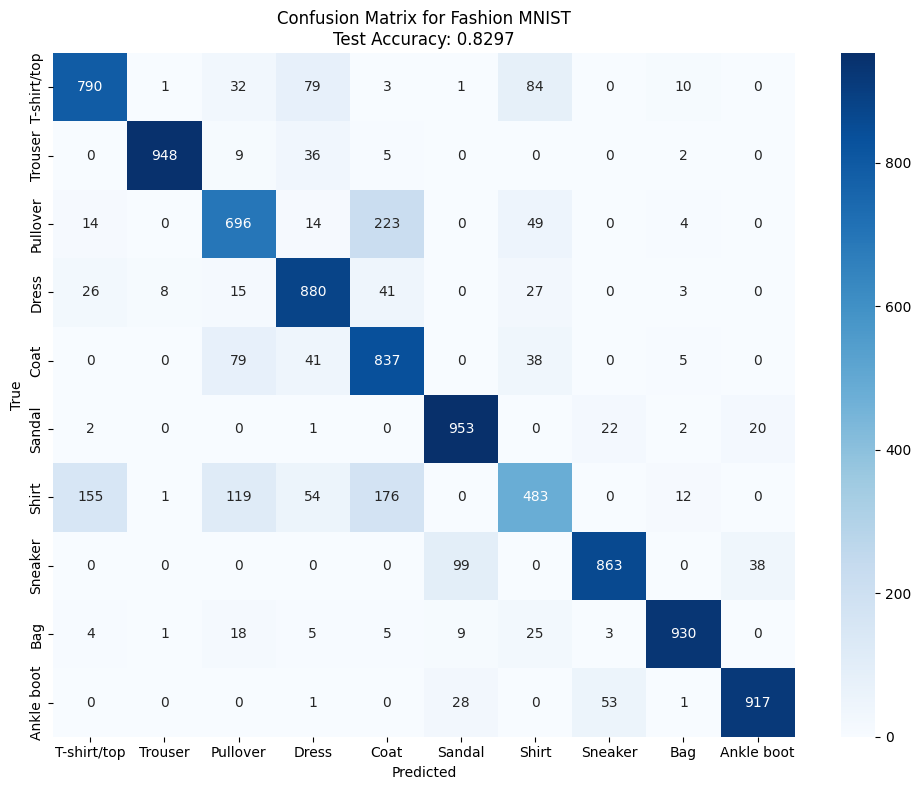


Per-Class Accuracy:
T-shirt/top: 0.7900
Trouser: 0.9480
Pullover: 0.6960
Dress: 0.8800
Coat: 0.8370
Sandal: 0.9530
Shirt: 0.4830
Sneaker: 0.8630
Bag: 0.9300
Ankle boot: 0.9170


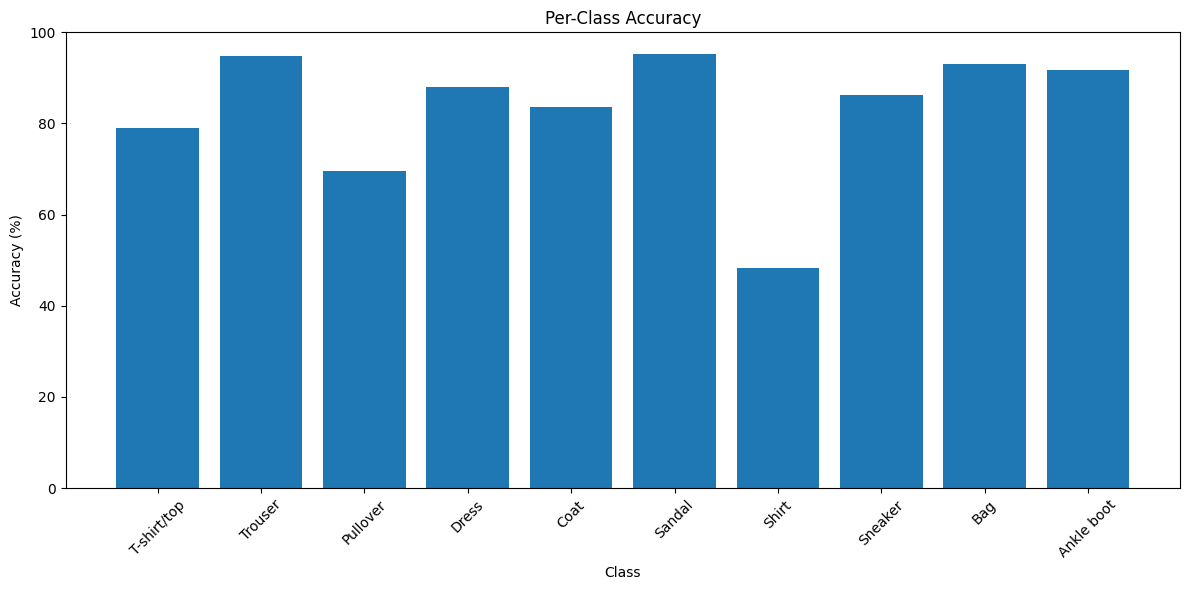


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.79      0.79      1000
     Trouser       0.99      0.95      0.97      1000
    Pullover       0.72      0.70      0.71      1000
       Dress       0.79      0.88      0.83      1000
        Coat       0.65      0.84      0.73      1000
      Sandal       0.87      0.95      0.91      1000
       Shirt       0.68      0.48      0.57      1000
     Sneaker       0.92      0.86      0.89      1000
         Bag       0.96      0.93      0.94      1000
  Ankle boot       0.94      0.92      0.93      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



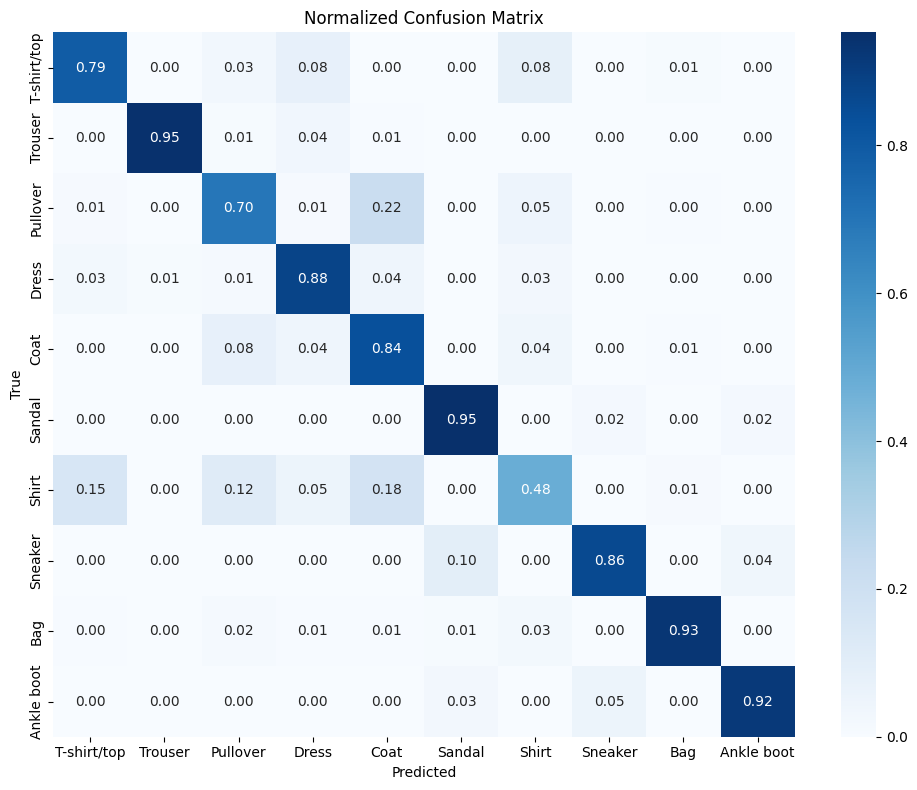

In [6]:
#Q7
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix

def tanh(x):
    return np.tanh(x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def forward(X, p, activation="tanh"):
    a = {0: X}
    A = X

    act_func = tanh

    for i, (W, b) in enumerate(p[:-1]):
        Z = np.dot(A, W) + b
        A = act_func(Z)
        a[i+1] = A

    W_out, b_out = p[-1]
    Z_out = np.dot(A, W_out) + b_out
    A_out = softmax(Z_out)

    a[len(p)] = A_out
    return A_out, a

def initialize_parameters(ls, init_method="xavier"):
    p = []m

    for i in range(len(ls) - 1):
        if init_method == "xavier":
            W = np.random.randn(ls[i], ls[i+1]) * np.sqrt(2 / (ls[i] + ls[i+1]))
        else:
            W = np.random.uniform(-0.1, 0.1, (layer_sizes[i], ls[i+1]))

        b = np.zeros((1, ls[i+1]))
        p.append((W, b))

    return p

(_, _), (X_test, y_test) = fashion_mnist.load_data()
X_test = X_test.reshape(-1, 28 * 28) / 255.0

input_size = 784
hidden_size = 128
num_hidden_layers = 4
output_size = 10


layer_sizes = [input_size] + [hidden_size] * num_hidden_layers + [output_size]
print(f"Network architecture: {layer_sizes}")

parameters = initialize_parameters(layer_sizes, init_method="xavier")

def train_nadam(X_train, y_train, parameters, epochs=10, batch_size=32, learning_rate=0.001):
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    t = 0

    first_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
    second_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}

    print("Training with Nadam optimizer...")
    for epoch in range(epochs):
        indices = np.random.permutation(X_train.shape[0])
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]

        batch_losses = []

        for i in range(0, X_train.shape[0], batch_size):
            t += 1
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            y_pred, layer_activations = forward(X_batch, parameters, activation="tanh")

            dZ = y_pred.copy()
            dZ[np.arange(len(y_batch)), y_batch] -= 1
            dZ /= len(y_batch)

            for j in range(len(parameters) - 1, -1, -1):
                W, b = parameters[j]
                A_prev = layer_activations[j]

                dW = np.dot(A_prev.T, dZ)
                db = np.sum(dZ, axis=0, keepdims=True)

                mW, mb = first_moment[j]
                vW, vb = second_moment[j]

                mW = beta1 * mW + (1 - beta1) * dW
                mb = beta1 * mb + (1 - beta1) * db

                vW = beta2 * vW + (1 - beta2) * (dW ** 2)
                vb = beta2 * vb + (1 - beta2) * (db ** 2)

                mW_hat = mW / (1 - beta1**t)
                mb_hat = mb / (1 - beta1**t)

                vW_hat = vW / (1 - beta2**t)
                vb_hat = vb / (1 - beta2**t)

                mW_nesterov = beta1 * mW_hat + (1 - beta1) * dW / (1 - beta1**t)
                mb_nesterov = beta1 * mb_hat + (1 - beta1) * db / (1 - beta1**t)

                W = W - learning_rate * mW_nesterov / (np.sqrt(vW_hat) + epsilon)
                b = b - learning_rate * mb_nesterov / (np.sqrt(vb_hat) + epsilon)

                parameters[j] = (W, b)
                first_moment[j] = (mW, mb)
                second_moment[j] = (vW, vb)

                if j > 0:
                    dZ = np.dot(dZ, W.T) * (1 - layer_activations[j]**2)

        if epoch % 2 == 0:
            eval_size = min(1000, X_train.shape[0])
            eval_pred, _ = forward(X_train[:eval_size], parameters, activation="tanh")
            eval_acc = np.mean(np.argmax(eval_pred, axis=1) == y_train[:eval_size])
            print(f"Epoch {epoch+1}/{epochs}, Training Accuracy (subset): {eval_acc:.4f}")

    return parameters

(X_train, y_train), _ = fashion_mnist.load_data()
X_train = X_train.reshape(-1, 28 * 28) / 255.0

X_train_subset = X_train[:5000]
y_train_subset = y_train[:5000]

trained_parameters = train_nadam(
    X_train_subset,
    y_train_subset,
    parameters,
    epochs=3,
    batch_size=32,
    learning_rate=0.001
)

y_pred_probs, _ = forward(X_test, trained_parameters, activation="tanh")
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = np.mean(y_pred == y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_test, y_pred)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for Fashion MNIST\nTest Accuracy: {accuracy:.4f}')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

class_accuracy = np.zeros(10)
for i in range(10):
    class_indices = (y_test == i)
    class_accuracy[i] = np.mean(y_pred[class_indices] == i)

print("\nPer-Class Accuracy:")
for i, name in enumerate(class_names):
    print(f"{name}: {class_accuracy[i]:.4f}")

plt.figure(figsize=(12, 6))
plt.bar(class_names, class_accuracy * 100)
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('per_class_accuracy.png')
plt.show()

from sklearn.metrics import classification_report, precision_recall_fscore_support

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

plt.figure(figsize=(10, 8))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.savefig('normalized_confusion_matrix.png')
plt.show()

Training models with Cross-Entropy Loss...
Training model: hl_4_bs_16_opt_nadam_ac_sigmoid_wd_0 with cross_entropy loss
Epoch 1/10, Train Loss: 1.4596, Val Loss: 0.9493, Val Acc: 0.6583
Epoch 2/10, Train Loss: 0.8029, Val Loss: 0.7258, Val Acc: 0.7163
Epoch 3/10, Train Loss: 0.6653, Val Loss: 0.6333, Val Acc: 0.7572
Epoch 4/10, Train Loss: 0.5918, Val Loss: 0.5734, Val Acc: 0.7827
Epoch 5/10, Train Loss: 0.5414, Val Loss: 0.5387, Val Acc: 0.7958
Epoch 6/10, Train Loss: 0.5094, Val Loss: 0.5004, Val Acc: 0.8085
Epoch 7/10, Train Loss: 0.4860, Val Loss: 0.4852, Val Acc: 0.8132
Epoch 8/10, Train Loss: 0.4669, Val Loss: 0.4666, Val Acc: 0.8250
Epoch 9/10, Train Loss: 0.4480, Val Loss: 0.4454, Val Acc: 0.8377
Epoch 10/10, Train Loss: 0.4285, Val Loss: 0.4322, Val Acc: 0.8470
Final Test Loss: 0.4642, Test Accuracy: 0.8349
Training model: hl_4_bs_32_opt_adam_ac_tanh_wd_0 with cross_entropy loss
Epoch 1/5, Train Loss: 0.6373, Val Loss: 0.4508, Val Acc: 0.8352
Epoch 2/5, Train Loss: 0.4269, Val

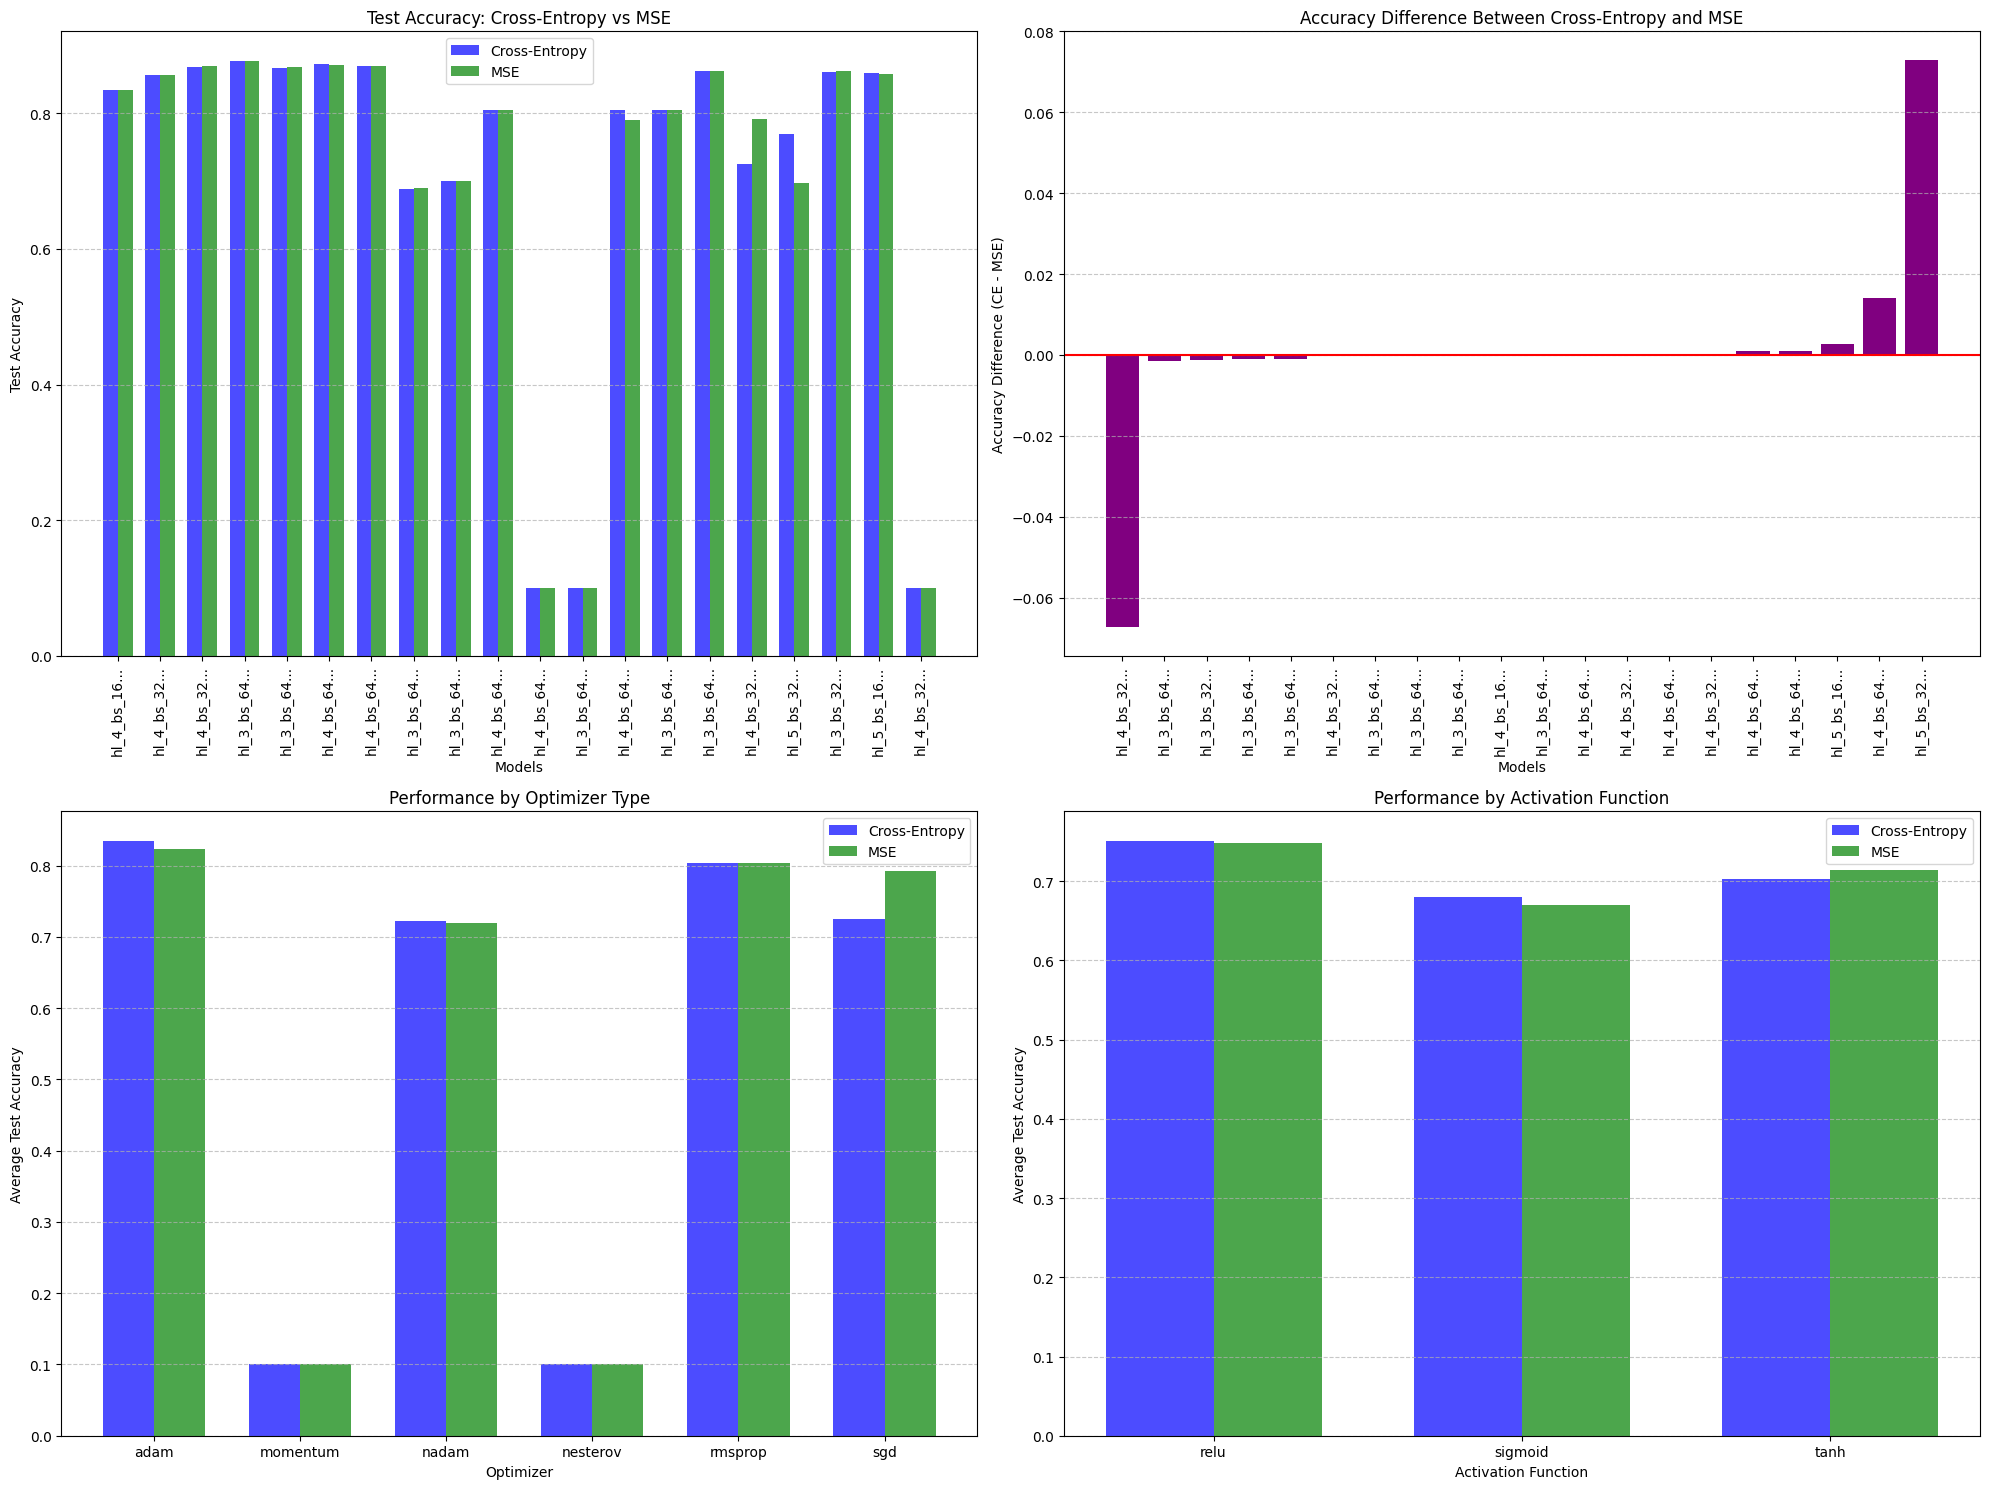

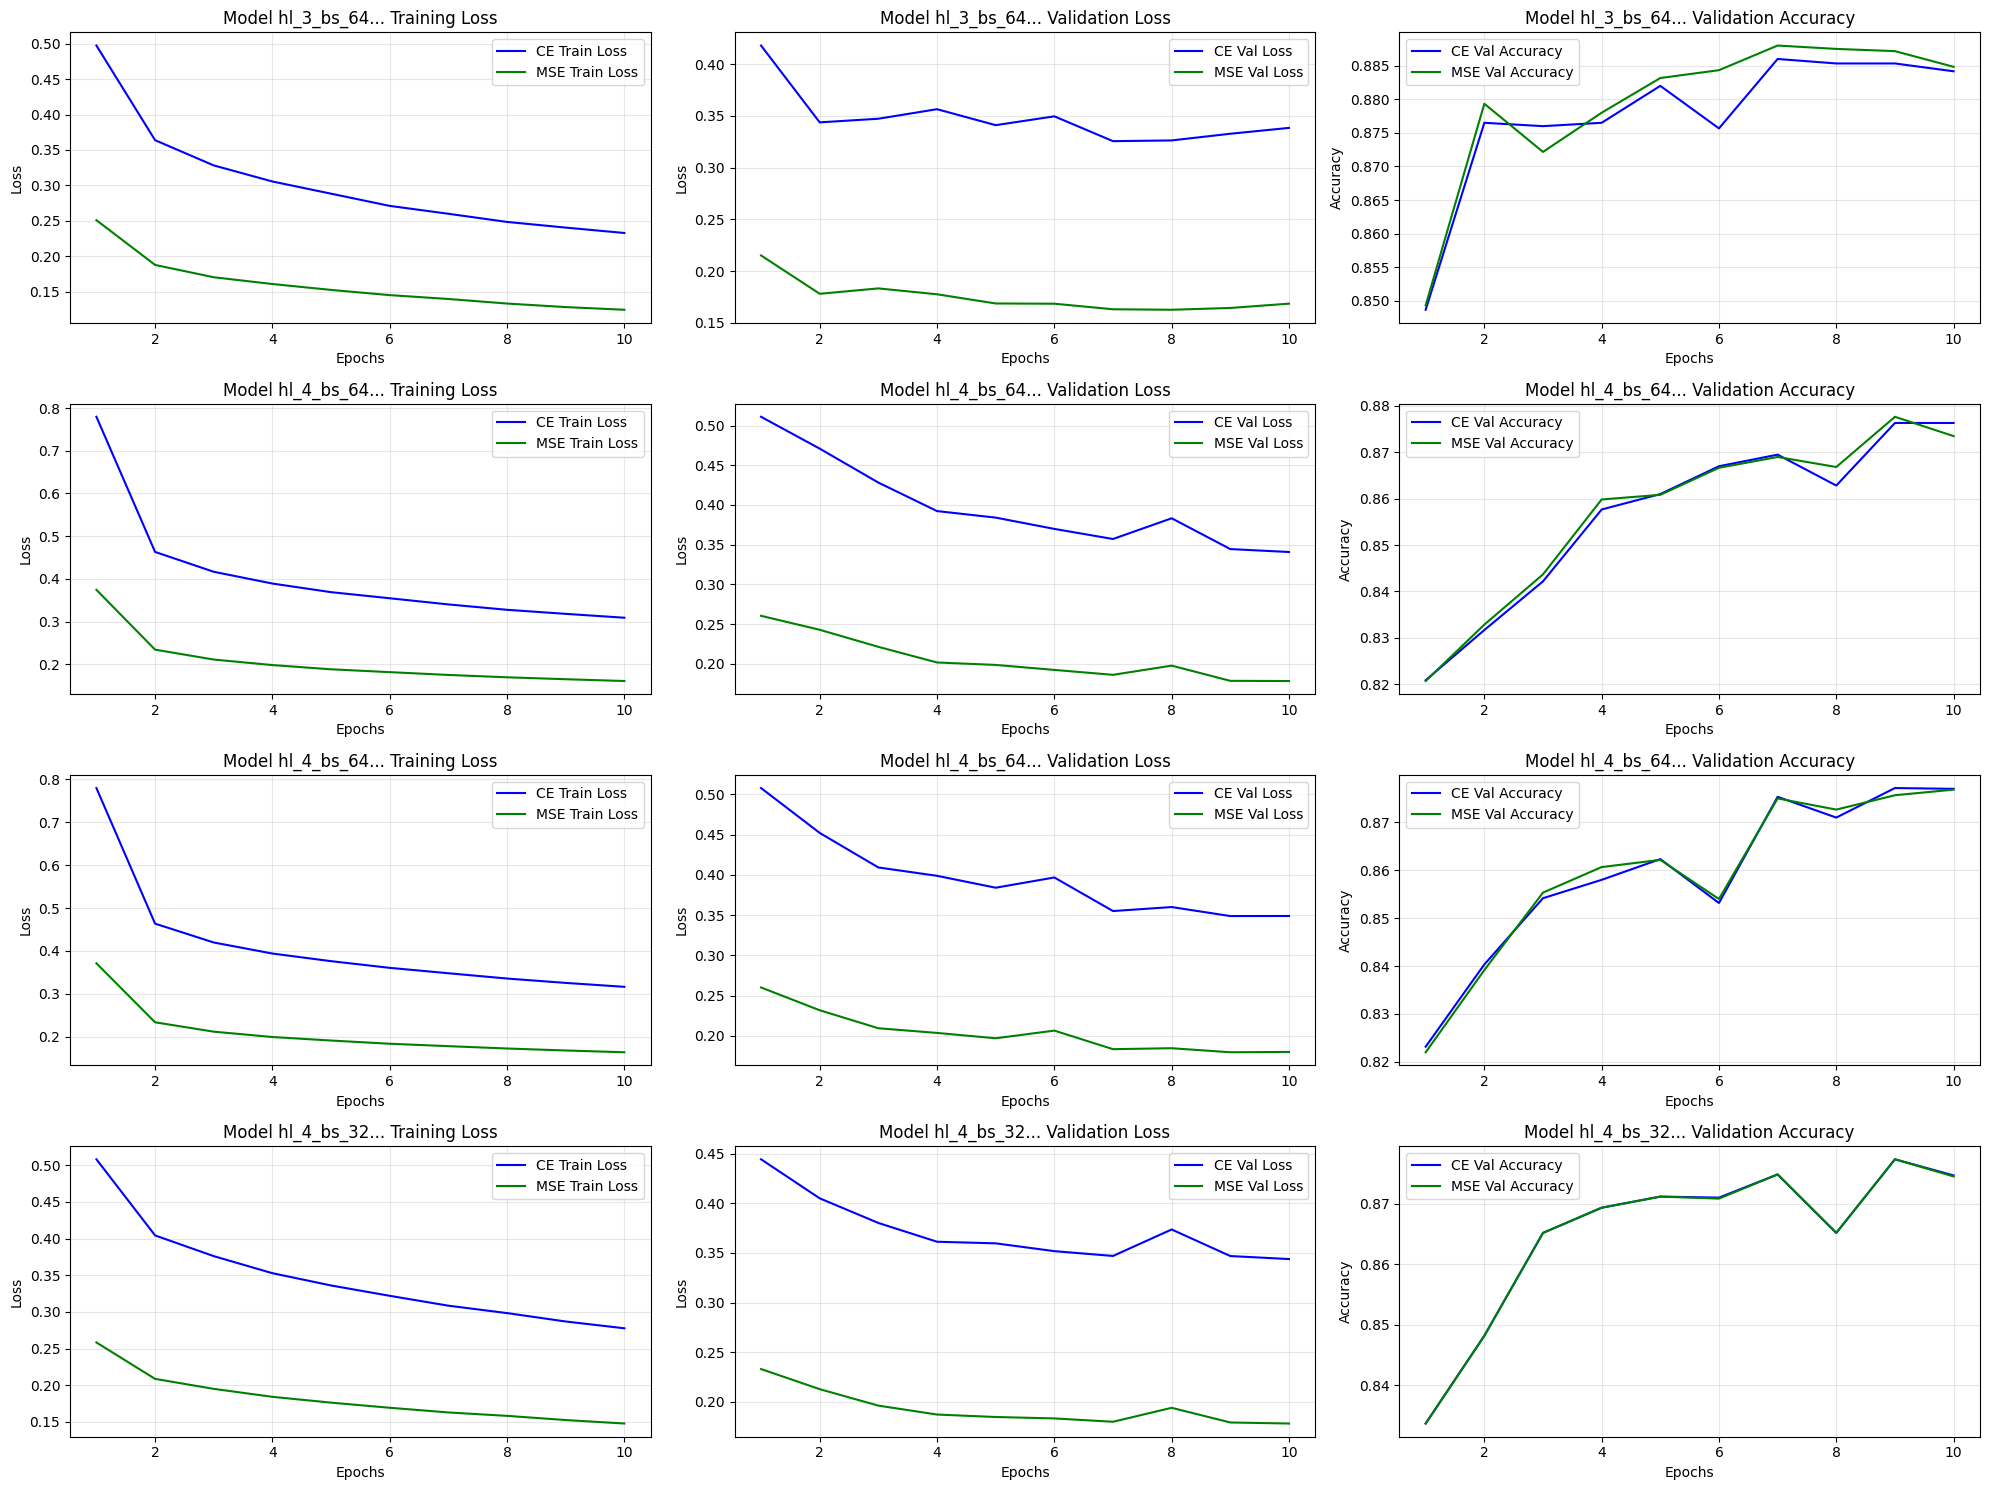


Summary Statistics:
Average CE Test Accuracy: 0.7116
Average MSE Test Accuracy: 0.7106
Average Accuracy Difference (CE-MSE): 0.0009

Cross-Entropy wins: 5/20 (25.0%)
MSE wins: 9/20 (45.0%)
Ties: 6/20 (30.0%)

Best model with Cross-Entropy loss:
Name: hl_3_bs_64_opt_nadam_ac_relu_wd_0
Optimizer: nadam
Activation: relu
Hidden Layers: 3
Hidden Size: 128
Test Accuracy: 0.8771

Best model with MSE loss:
Name: hl_3_bs_64_opt_nadam_ac_relu_wd_0
Optimizer: nadam
Activation: relu
Hidden Layers: 3
Hidden Size: 128
Test Accuracy: 0.8773


In [7]:
#Q8
import matplotlib.pyplot as plt
import seaborn as sns

def train_model_with_loss(loss_type="cross_entropy"):
  # Previously used models
    configs = [
        {"epochs": 10, "num_hidden_layers": 4, "hidden_size": 128, "weight_decay": 0.0, "learning_rate": 0.0001, "optimizer": "nadam", "batch_size": 16, "weight_init": "xavier", "activation": "sigmoid", "name": "hl_4_bs_16_opt_nadam_ac_sigmoid_wd_0"},
        {"epochs": 5, "num_hidden_layers": 4, "hidden_size": 128, "weight_decay": 0.0, "learning_rate": 0.0001, "optimizer": "adam", "batch_size": 32, "weight_init": "xavier", "activation": "tanh", "name": "hl_4_bs_32_opt_adam_ac_tanh_wd_0"},
        {"epochs": 10, "num_hidden_layers": 4, "hidden_size": 128, "weight_decay": 0.0, "learning_rate": 0.001, "optimizer": "adam", "batch_size": 32, "weight_init": "xavier", "activation": "tanh", "name": "hl_4_bs_32_opt_adam_ac_tanh_wd_0_lr_001"},
        {"epochs": 10, "num_hidden_layers": 3, "hidden_size": 128, "weight_decay": 0.0, "learning_rate": 0.001, "optimizer": "nadam", "batch_size": 64, "weight_init": "xavier", "activation": "relu", "name": "hl_3_bs_64_opt_nadam_ac_relu_wd_0"},
        {"epochs": 10, "num_hidden_layers": 3, "hidden_size": 128, "weight_decay": 0.0, "learning_rate": 0.0001, "optimizer": "nadam", "batch_size": 64, "weight_init": "xavier", "activation": "relu", "name": "hl_3_bs_64_opt_nadam_ac_relu_wd_0_lr_0001"},
        {"epochs": 10, "num_hidden_layers": 4, "hidden_size": 128, "weight_decay": 0.0, "learning_rate": 0.0001, "optimizer": "adam", "batch_size": 64, "weight_init": "xavier", "activation": "relu", "name": "hl_4_bs_64_opt_adam_ac_relu_wd_0"},
        {"epochs": 10, "num_hidden_layers": 4, "hidden_size": 128, "weight_decay": 0.0, "learning_rate": 0.0001, "optimizer": "nadam", "batch_size": 64, "weight_init": "xavier", "activation": "relu", "name": "hl_4_bs_64_opt_nadam_ac_relu_wd_0"},
        {"epochs": 10, "num_hidden_layers": 3, "hidden_size": 128, "weight_decay": 0.0, "learning_rate": 0.0001, "optimizer": "rmsprop", "batch_size": 64, "weight_init": "random", "activation": "sigmoid", "name": "hl_3_bs_64_opt_rmsprop_ac_sigmoid_wd_0"},
        {"epochs": 10, "num_hidden_layers": 3, "hidden_size": 128, "weight_decay": 0.0, "learning_rate": 0.0001, "optimizer": "nadam", "batch_size": 64, "weight_init": "random", "activation": "sigmoid", "name": "hl_3_bs_64_opt_nadam_ac_sigmoid_wd_0"},
        {"epochs": 10, "num_hidden_layers": 4, "hidden_size": 128, "weight_decay": 0.0, "learning_rate": 0.0001, "optimizer": "adam", "batch_size": 64, "weight_init": "xavier", "activation": "sigmoid", "name": "hl_4_bs_64_opt_adam_ac_sigmoid_wd_0"},
        {"epochs": 10, "num_hidden_layers": 4, "hidden_size": 128, "weight_decay": 0.0, "learning_rate": 0.0001, "optimizer": "nesterov", "batch_size": 64, "weight_init": "random", "activation": "tanh", "name": "hl_4_bs_64_opt_nesterov_ac_tanh_wd_0"},
        {"epochs": 10, "num_hidden_layers": 3, "hidden_size": 64, "weight_decay": 0.5, "learning_rate": 0.0001, "optimizer": "nadam", "batch_size": 64, "weight_init": "random", "activation": "relu", "name": "hl_3_bs_64_opt_nadam_ac_relu_wd_0.5"},
        {"epochs": 10, "num_hidden_layers": 4, "hidden_size": 128, "weight_decay": 0.0, "learning_rate": 0.0001, "optimizer": "nadam", "batch_size": 64, "weight_init": "random", "activation": "relu", "name": "hl_4_bs_64_opt_nadam_ac_relu_wd_0_random"},
        {"epochs": 10, "num_hidden_layers": 3, "hidden_size": 128, "weight_decay": 0.0, "learning_rate": 0.0001, "optimizer": "adam", "batch_size": 64, "weight_init": "random", "activation": "tanh", "name": "hl_3_bs_64_opt_adam_ac_tanh_wd_0"},
        {"epochs": 10, "num_hidden_layers": 3, "hidden_size": 128, "weight_decay": 0.0, "learning_rate": 0.001, "optimizer": "rmsprop", "batch_size": 64, "weight_init": "random", "activation": "sigmoid", "name": "hl_3_bs_64_opt_rmsprop_ac_sigmoid_wd_0_lr_001"},
        {"epochs": 5, "num_hidden_layers": 4, "hidden_size": 32, "weight_decay": 0.0, "learning_rate": 0.001, "optimizer": "sgd", "batch_size": 32, "weight_init": "xavier", "activation": "tanh", "name": "hl_4_bs_32_opt_sgd_ac_tanh_wd_0"},
        {"epochs": 5, "num_hidden_layers": 5, "hidden_size": 128, "weight_decay": 0.0, "learning_rate": 0.001, "optimizer": "adam", "batch_size": 32, "weight_init": "random", "activation": "sigmoid", "name": "hl_5_bs_32_opt_adam_ac_sigmoid_wd_0"},
        {"epochs": 10, "num_hidden_layers": 3, "hidden_size": 64, "weight_decay": 0.0005, "learning_rate": 0.0001, "optimizer": "adam", "batch_size": 32, "weight_init": "xavier", "activation": "relu", "name": "hl_3_bs_32_opt_adam_ac_relu_wd_0.0005"},
        {"epochs": 10, "num_hidden_layers": 5, "hidden_size": 64, "weight_decay": 0.0, "learning_rate": 0.001, "optimizer": "rmsprop", "batch_size": 16, "weight_init": "xavier", "activation": "tanh", "name": "hl_5_bs_16_opt_rmsprop_ac_tanh_wd_0"},
        {"epochs": 5, "num_hidden_layers": 4, "hidden_size": 64, "weight_decay": 0.0, "learning_rate": 0.0001, "optimizer": "momentum", "batch_size": 32, "weight_init": "random", "activation": "sigmoid", "name": "hl_4_bs_32_opt_momentum_ac_sigmoid_wd_0"}
    ]

    (X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
    X_train_full = X_train_full.reshape(-1, 28 * 28) / 255.0
    X_test = X_test.reshape(-1, 28 * 28) / 255.0

    X_train, X_val, y_train, y_val = create_train_val_split(
        X_train_full, y_train_full, val_ratio=0.1, random_seed=42
    )

    results = []

    for config in configs:
        print(f"Training model: {config['name']} with {loss_type} loss")

        input_size = X_train.shape[1]
        output_size = 10

        hidden_layers = [config['hidden_size']] * config['num_hidden_layers']
        layer_sizes = [input_size] + hidden_layers + [output_size]

        if config['weight_init'] == "xavier":
            parameters = initialize_parameters(layer_sizes, init_method="xavier")
        else:
            parameters = initialize_parameters(layer_sizes, init_method="random")

        def custom_compute_loss(Y_pred, Y_true, parameters=None, weight_decay=0):
            m = Y_true.shape[0]

            if loss_type == "cross_entropy":
                cross_entropy = -np.mean(np.log(Y_pred[np.arange(m), Y_true] + 1e-9))

                reg_term = 0
                if weight_decay > 0 and parameters is not None:
                    for W, _ in parameters:
                        reg_term += 0.5 * weight_decay * np.sum(np.square(W))

                return cross_entropy + reg_term

            elif loss_type == "mse":
                one_hot_true = np.zeros((m, 10))
                one_hot_true[np.arange(m), Y_true] = 1
                mse = np.mean(np.sum((Y_pred - one_hot_true) ** 2, axis=1))

                reg_term = 0
                if weight_decay > 0 and parameters is not None:
                    for W, _ in parameters:
                        reg_term += 0.5 * weight_decay * np.sum(np.square(W))

                return mse + reg_term

        def custom_backward(X, Y, parameters, a, activation="sigmoid", weight_decay=0):
            m = X.shape[0]
            gradients = {}

            act_deriv = sigmoid_derivative
            if activation == "tanh":
                act_deriv = tanh_derivative
            elif activation == "relu":
                act_deriv = relu_derivative

            A_out = a[len(parameters)]

            if loss_type == "cross_entropy":
                dZ_out = A_out.copy()
                dZ_out[np.arange(m), Y] -= 1
                dZ_out /= m

            elif loss_type == "mse":
                one_hot_true = np.zeros((m, 10))
                one_hot_true[np.arange(m), Y] = 1
                dZ_out = 2 * (A_out - one_hot_true) / m

            W_out = parameters[-1][0]
            reg_term = 0
            if weight_decay > 0:
                reg_term = weight_decay * W_out

            gradients[len(parameters)] = (np.dot(a[len(parameters)-1].T, dZ_out) + reg_term,
                                      np.sum(dZ_out, axis=0, keepdims=True))

            dA = np.dot(dZ_out, parameters[-1][0].T)

            for i in reversed(range(len(parameters) - 1)):
                if activation == "relu":
                    prev_A = a[i]
                    W, b = parameters[i]
                    Z = np.dot(prev_A, W) + b
                    dZ = dA * relu_derivative(Z)
                else:
                    dZ = dA * act_deriv(a[i+1])

                W = parameters[i][0]
                reg_term = 0
                if weight_decay > 0:
                    reg_term = weight_decay * W

                gradients[i+1] = (np.dot(a[i].T, dZ) + reg_term,
                             np.sum(dZ, axis=0, keepdims=True))

                dA = np.dot(dZ, parameters[i][0].T)

            return gradients

        optimizer_type = config['optimizer']
        weight_decay = config['weight_decay']
        batch_size = config['batch_size']
        learning_rate = config['learning_rate']
        epochs = config['epochs']

        train_losses = []
        val_losses = []
        val_accuracies = []

        if optimizer_type == "sgd":
            for epoch in range(epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    y_pred, layer_activations = forward(X_batch, parameters, activation=config['activation'])

                    gradients = custom_backward(X_batch, y_batch, parameters, layer_activations,
                                          activation=config['activation'], weight_decay=weight_decay)

                    parameters = update_parameters(parameters, gradients, learning_rate)

                    batch_loss = custom_compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)
                train_losses.append(epoch_loss)

                val_pred, _ = forward(X_val, parameters, activation=config['activation'])
                val_loss = custom_compute_loss(val_pred, y_val, parameters, weight_decay)
                val_losses.append(val_loss)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)
                val_accuracies.append(val_acc)

                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer_type == "momentum":
            momentum_values = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta = 0.9

            for epoch in range(epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    y_pred, layer_activations = forward(X_batch, parameters, activation=config['activation'])

                    gradients = custom_backward(X_batch, y_batch, parameters, layer_activations,
                                          activation=config['activation'], weight_decay=weight_decay)

                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = gradients[j+1]
                        vW, vb = momentum_values[j]

                        vW = beta * vW - learning_rate * dW
                        vb = beta * vb - learning_rate * db

                        W = W + vW
                        b = b + vb

                        parameters[j] = (W, b)
                        momentum_values[j] = (vW, vb)

                    batch_loss = custom_compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)
                train_losses.append(epoch_loss)

                val_pred, _ = forward(X_val, parameters, activation=config['activation'])
                val_loss = custom_compute_loss(val_pred, y_val, parameters, weight_decay)
                val_losses.append(val_loss)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)
                val_accuracies.append(val_acc)

                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer_type == "nesterov":
            momentum_values = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta = 0.9

            for epoch in range(epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    lookahead_parameters = []
                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        vW, vb = momentum_values[j]
                        lookahead_W = W + beta * vW
                        lookahead_b = b + beta * vb
                        lookahead_parameters.append((lookahead_W, lookahead_b))

                    y_pred, layer_activations = forward(X_batch, lookahead_parameters, activation=config['activation'])

                    gradients = custom_backward(X_batch, y_batch, lookahead_parameters, layer_activations,
                                          activation=config['activation'], weight_decay=weight_decay)

                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = gradients[j+1]
                        vW, vb = momentum_values[j]

                        vW = beta * vW - learning_rate * dW
                        vb = beta * vb - learning_rate * db

                        W = W + vW
                        b = b + vb

                        parameters[j] = (W, b)
                        momentum_values[j] = (vW, vb)

                    batch_loss = custom_compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)
                train_losses.append(epoch_loss)

                val_pred, _ = forward(X_val, parameters, activation=config['activation'])
                val_loss = custom_compute_loss(val_pred, y_val, parameters, weight_decay)
                val_losses.append(val_loss)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)
                val_accuracies.append(val_acc)

                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer_type == "rmsprop":
            squared_grads = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta = 0.9
            epsilon = 1e-8

            for epoch in range(epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    y_pred, layer_activations = forward(X_batch, parameters, activation=config['activation'])

                    gradients = custom_backward(X_batch, y_batch, parameters, layer_activations,
                                          activation=config['activation'], weight_decay=weight_decay)

                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = gradients[j+1]
                        sW, sb = squared_grads[j]

                        sW = beta * sW + (1 - beta) * (dW ** 2)
                        sb = beta * sb + (1 - beta) * (db ** 2)

                        W = W - learning_rate * dW / (np.sqrt(sW) + epsilon)
                        b = b - learning_rate * db / (np.sqrt(sb) + epsilon)

                        parameters[j] = (W, b)
                        squared_grads[j] = (sW, sb)

                    batch_loss = custom_compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)
                train_losses.append(epoch_loss)

                val_pred, _ = forward(X_val, parameters, activation=config['activation'])
                val_loss = custom_compute_loss(val_pred, y_val, parameters, weight_decay)
                val_losses.append(val_loss)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)
                val_accuracies.append(val_acc)

                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer_type == "adam" or optimizer_type == "nadam":
            first_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            second_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta1 = 0.9
            beta2 = 0.999
            epsilon = 1e-8
            t = 0

            for epoch in range(epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    t += 1
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    y_pred, layer_activations = forward(X_batch, parameters, activation=config['activation'])

                    gradients = custom_backward(X_batch, y_batch, parameters, layer_activations,
                                          activation=config['activation'], weight_decay=weight_decay)

                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = gradients[j+1]
                        mW, mb = first_moment[j]
                        vW, vb = second_moment[j]

                        mW = beta1 * mW + (1 - beta1) * dW
                        mb = beta1 * mb + (1 - beta1) * db

                        vW = beta2 * vW + (1 - beta2) * (dW ** 2)
                        vb = beta2 * vb + (1 - beta2) * (db ** 2)

                        mW_hat = mW / (1 - beta1**t)
                        mb_hat = mb / (1 - beta1**t)

                        vW_hat = vW / (1 - beta2**t)
                        vb_hat = vb / (1 - beta2**t)

                        if optimizer_type == "nadam":
                            mW_nesterov = beta1 * mW_hat + (1 - beta1) * dW / (1 - beta1**t)
                            mb_nesterov = beta1 * mb_hat + (1 - beta1) * db / (1 - beta1**t)

                            W = W - learning_rate * mW_nesterov / (np.sqrt(vW_hat) + epsilon)
                            b = b - learning_rate * mb_nesterov / (np.sqrt(vb_hat) + epsilon)
                        else:
                            W = W - learning_rate * mW_hat / (np.sqrt(vW_hat) + epsilon)
                            b = b - learning_rate * mb_hat / (np.sqrt(vb_hat) + epsilon)

                        parameters[j] = (W, b)
                        first_moment[j] = (mW, mb)
                        second_moment[j] = (vW, vb)

                    batch_loss = custom_compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)
                train_losses.append(epoch_loss)

                val_pred, _ = forward(X_val, parameters, activation=config['activation'])
                val_loss = custom_compute_loss(val_pred, y_val, parameters, weight_decay)
                val_losses.append(val_loss)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)
                val_accuracies.append(val_acc)

                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        test_pred, _ = forward(X_test, parameters, activation=config['activation'])
        test_acc = np.mean(np.argmax(test_pred, axis=1) == y_test)
        test_loss = custom_compute_loss(test_pred, y_test, parameters, weight_decay)

        print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

        results.append({
            'name': config['name'],
            'optimizer': optimizer_type,
            'activation': config['activation'],
            'num_hidden_layers': config['num_hidden_layers'],
            'hidden_size': config['hidden_size'],
            'weight_decay': weight_decay,
            'test_accuracy': test_acc,
            'test_loss': test_loss,
            'val_accuracy': val_accuracies[-1],
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        })

    return results

def compare_loss_functions():
    print("Training models with Cross-Entropy Loss...")
    ce_results = train_model_with_loss("cross_entropy")

    print("\nTraining models with Mean Squared Error Loss...")
    mse_results = train_model_with_loss("mse")

    combined_results = []
    for ce_model, mse_model in zip(ce_results, mse_results):
        combined_results.append({
            'name': ce_model['name'],
            'optimizer': ce_model['optimizer'],
            'activation': ce_model['activation'],
            'num_hidden_layers': ce_model['num_hidden_layers'],
            'hidden_size': ce_model['hidden_size'],
            'ce_test_accuracy': ce_model['test_accuracy'],
            'mse_test_accuracy': mse_model['test_accuracy'],
            'accuracy_diff': ce_model['test_accuracy'] - mse_model['test_accuracy'],
            'ce_test_loss': ce_model['test_loss'],
            'mse_test_loss': mse_model['test_loss']
        })

    results_df = pd.DataFrame(combined_results)

    plt.figure(figsize=(20, 15))

    plt.subplot(2, 2, 1)
    models = results_df['name'].apply(lambda x: x[:10] + '...')
    bar_width = 0.35
    index = np.arange(len(models))

    plt.bar(index - bar_width/2, results_df['ce_test_accuracy'], bar_width,
            label='Cross-Entropy', color='blue', alpha=0.7)
    plt.bar(index + bar_width/2, results_df['mse_test_accuracy'], bar_width,
            label='MSE', color='green', alpha=0.7)

    plt.xlabel('Models')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy: Cross-Entropy vs MSE')
    plt.xticks(index, models, rotation=90)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.subplot(2, 2, 2)
    sorted_diff = results_df.sort_values('accuracy_diff')
    models_sorted = sorted_diff['name'].apply(lambda x: x[:10] + '...')
    plt.bar(range(len(sorted_diff)), sorted_diff['accuracy_diff'], color='purple')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Models')
    plt.ylabel('Accuracy Difference (CE - MSE)')
    plt.title('Accuracy Difference Between Cross-Entropy and MSE')
    plt.xticks(range(len(sorted_diff)), models_sorted, rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.subplot(2, 2, 3)
    optimizer_performance = results_df.groupby('optimizer')[['ce_test_accuracy', 'mse_test_accuracy']].mean().reset_index()

    bar_width = 0.35
    index = np.arange(len(optimizer_performance))

    plt.bar(index - bar_width/2, optimizer_performance['ce_test_accuracy'], bar_width,
            label='Cross-Entropy', color='blue', alpha=0.7)
    plt.bar(index + bar_width/2, optimizer_performance['mse_test_accuracy'], bar_width,
            label='MSE', color='green', alpha=0.7)

    plt.xlabel('Optimizer')
    plt.ylabel('Average Test Accuracy')
    plt.title('Performance by Optimizer Type')
    plt.xticks(index, optimizer_performance['optimizer'])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.subplot(2, 2, 4)
    activation_performance = results_df.groupby('activation')[['ce_test_accuracy', 'mse_test_accuracy']].mean().reset_index()

    index = np.arange(len(activation_performance))

    plt.bar(index - bar_width/2, activation_performance['ce_test_accuracy'], bar_width,
            label='Cross-Entropy', color='blue', alpha=0.7)
    plt.bar(index + bar_width/2, activation_performance['mse_test_accuracy'], bar_width,
            label='MSE', color='green', alpha=0.7)

    plt.xlabel('Activation Function')
    plt.ylabel('Average Test Accuracy')
    plt.title('Performance by Activation Function')
    plt.xticks(index, activation_performance['activation'])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('loss_function_comparison.png', dpi=300)
    plt.show()

    plt.figure(figsize=(20, 15))

    selected_models = results_df.sort_values('ce_test_accuracy', ascending=False).iloc[:4]['name'].tolist()

    for i, model_name in enumerate(selected_models):
        ce_model = next(model for model in ce_results if model['name'] == model_name)
        mse_model = next(model for model in mse_results if model['name'] == model_name)

        epochs = range(1, len(ce_model['train_losses']) + 1)

        plt.subplot(4, 3, i*3 + 1)
        plt.plot(epochs, ce_model['train_losses'], 'b-', label='CE Train Loss')
        plt.plot(epochs, mse_model['train_losses'], 'g-', label='MSE Train Loss')
        plt.title(f'Model {model_name[:10]}... Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(4, 3, i*3 + 2)
        plt.plot(epochs, ce_model['val_losses'], 'b-', label='CE Val Loss')
        plt.plot(epochs, mse_model['val_losses'], 'g-', label='MSE Val Loss')
        plt.title(f'Model {model_name[:10]}... Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(4, 3, i*3 + 3)
        plt.plot(epochs, ce_model['val_accuracies'], 'b-', label='CE Val Accuracy')
        plt.plot(epochs, mse_model['val_accuracies'], 'g-', label='MSE Val Accuracy')
        plt.title(f'Model {model_name[:10]}... Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('learning_curves_comparison.png', dpi=300)
    plt.show()

    print("\nSummary Statistics:")
    print(f"Average CE Test Accuracy: {results_df['ce_test_accuracy'].mean():.4f}")
    print(f"Average MSE Test Accuracy: {results_df['mse_test_accuracy'].mean():.4f}")
    print(f"Average Accuracy Difference (CE-MSE): {results_df['accuracy_diff'].mean():.4f}")

    ce_wins = sum(results_df['accuracy_diff'] > 0)
    mse_wins = sum(results_df['accuracy_diff'] < 0)
    ties = sum(results_df['accuracy_diff'] == 0)

    print(f"\nCross-Entropy wins: {ce_wins}/{len(results_df)} ({ce_wins/len(results_df)*100:.1f}%)")
    print(f"MSE wins: {mse_wins}/{len(results_df)} ({mse_wins/len(results_df)*100:.1f}%)")
    print(f"Ties: {ties}/{len(results_df)} ({ties/len(results_df)*100:.1f}%)")

    print("\nBest model with Cross-Entropy loss:")
    best_ce_idx = results_df['ce_test_accuracy'].idxmax()
    best_ce_model = results_df.iloc[best_ce_idx]
    print(f"Name: {best_ce_model['name']}")
    print(f"Optimizer: {best_ce_model['optimizer']}")
    print(f"Activation: {best_ce_model['activation']}")
    print(f"Hidden Layers: {best_ce_model['num_hidden_layers']}")
    print(f"Hidden Size: {best_ce_model['hidden_size']}")
    print(f"Test Accuracy: {best_ce_model['ce_test_accuracy']:.4f}")

    print("\nBest model with MSE loss:")
    best_mse_idx = results_df['mse_test_accuracy'].idxmax()
    best_mse_model = results_df.iloc[best_mse_idx]
    print(f"Name: {best_mse_model['name']}")
    print(f"Optimizer: {best_mse_model['optimizer']}")
    print(f"Activation: {best_mse_model['activation']}")
    print(f"Hidden Layers: {best_mse_model['num_hidden_layers']}")
    print(f"Hidden Size: {best_mse_model['hidden_size']}")
    print(f"Test Accuracy: {best_mse_model['mse_test_accuracy']:.4f}")
    return results_df

if __name__ == "__main__":
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from tensorflow.keras.datasets import fashion_mnist

    def create_train_val_split(X, y, val_ratio=0.1, random_seed=None):
        if random_seed is not None:
            np.random.seed(random_seed)

        m = X.shape[0]
        indices = np.random.permutation(m)
        val_size = int(m * val_ratio)

        val_indices = indices[:val_size]
        train_indices = indices[val_size:]

        return X[train_indices], X[val_indices], y[train_indices], y[val_indices]

    def initialize_parameters(layer_sizes, init_method="random"):
        parameters = []
        L = len(layer_sizes)

        for l in range(1, L):
            if init_method == "xavier":
                W = np.random.randn(layer_sizes[l-1], layer_sizes[l]) * np.sqrt(1 / layer_sizes[l-1])
            else:
                W = np.random.randn(layer_sizes[l-1], layer_sizes[l]) * 0.01

            b = np.zeros((1, layer_sizes[l]))
            parameters.append((W, b))

        return parameters

    def sigmoid(Z):
        return 1 / (1 + np.exp(-np.clip(Z, -709, 709)))

    def tanh(Z):
        return np.tanh(Z)

    def relu(Z):
        return np.maximum(0, Z)

    def sigmoid_derivative(A):
        return A * (1 - A)

    def tanh_derivative(Z):
        return 1 - np.power(np.tanh(Z), 2)

    def relu_derivative(Z):
        return np.where(Z > 0, 1, 0)

    def softmax(Z):
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def forward(X, parameters, activation="sigmoid"):
        A = X
        activations = [A]

        for i, (W, b) in enumerate(parameters):
            Z = np.dot(A, W) + b

            if i == len(parameters) - 1:
                A = softmax(Z)
            else:
                if activation == "sigmoid":
                    A = sigmoid(Z)
                elif activation == "tanh":
                    A = tanh(Z)
                elif activation == "relu":
                    A = relu(Z)

            activations.append(A)

        return activations[-1], activations

    def update_parameters(parameters, gradients, learning_rate):
        updated_parameters = []

        for i, (W, b) in enumerate(parameters):
            dW, db = gradients[i+1]

            W = W - learning_rate * dW
            b = b - learning_rate * db

            updated_parameters.append((W, b))

        return updated_parameters

    results = compare_loss_functions()

In [4]:
#Q2 to Q6
import numpy as np
import wandb
import pandas as pd
from tensorflow.keras.datasets import mnist

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

def sigmoid_derivative(x):
    return x * (1 - x)

def tanh_derivative(x):
    return 1 - np.power(x, 2)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def initialize_parameters(layer_sizes, init_method="random", weight_decay=0):
    np.random.seed(1)
    p = []

    for i in range(len(layer_sizes) - 1):
        if init_method == "random":
            W = np.random.uniform(-0.1, 0.1, (layer_sizes[i], layer_sizes[i+1]))
        elif init_method == "xavier":
            W = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / (layer_sizes[i] + layer_sizes[i+1]))

        b = np.zeros((1, layer_sizes[i+1]))
        p.append((W, b))

    return p

def forward(X, p, activation="sigmoid"):
    a = {0: X}
    A = X

    act_func = sigmoid
    if activation == "tanh":
        act_func = tanh
    elif activation == "relu":
        act_func = relu

    for i, (W, b) in enumerate(p[:-1]):
        Z = np.dot(A, W) + b
        A = act_func(Z)
        a[i+1] = A

    W_out, b_out = p[-1]
    Z_out = np.dot(A, W_out) + b_out
    A_out = softmax(Z_out)

    a[len(p)] = A_out
    return A_out, a

def backward(X, Y, p, a, activation="sigmoid", wd=0):
    m = X.shape[0]
    gradients = {}

    act_deriv = sigmoid_derivative
    if activation == "tanh":
        act_deriv = tanh_derivative
    elif activation == "relu":
        act_deriv = relu_derivative

    A_out = a[len(p)]
    dZ_out = A_out.copy()
    dZ_out[np.arange(m), Y] -= 1
    dZ_out /= m

    W_out = p[-1][0]
    reg_term = 0
    if wd > 0:
        reg_term = wd * W_out

    gradients[len(p)] = (np.dot(a[len(p)-1].T, dZ_out) + reg_term,
                              np.sum(dZ_out, axis=0, keepdims=True))

    dA = np.dot(dZ_out, p[-1][0].T)

    for i in reversed(range(len(p) - 1)):
        if activation == "relu":
            if i == 0:
                prev_A = a[i]
            else:
                prev_A = a[i]

            W, b = p[i]
            Z = np.dot(prev_A, W) + b
            dZ = dA * relu_derivative(Z)
        else:
            dZ = dA * act_deriv(a[i+1])

        W = p[i][0]
        reg_term = 0
        if wd > 0:
            reg_term = wd * W

        gradients[i+1] = (np.dot(a[i].T, dZ) + reg_term,
                     np.sum(dZ, axis=0, keepdims=True))

        dA = np.dot(dZ, p[i][0].T)

    return gradients

def compute_loss(Y_pred, Y_true, p=None, wd=0):
    cross_entropy = -np.mean(np.log(Y_pred[np.arange(Y_true.shape[0]), Y_true] + 1e-9))

    reg_term = 0
    if wd > 0 and p is not None:
        for W, _ in p:
            reg_term += 0.5 * wd * np.sum(np.square(W))

    return cross_entropy + reg_term

def update_parameters(p, g, lr):
    for i in range(len(p)):
        W, b = p[i]
        dW, db = g[i+1]
        W = W - lr * dW
        b = b - lr * db
        p[i] = (W, b)
    return p

def create_train_val_split(X, y, val_ratio=0.1, random_seed=1):
    np.random.seed(random_seed)
    indices = np.random.permutation(len(X))
    val_size = int(len(X) * val_ratio)
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]

    X_train = X[train_indices]
    y_train = y[train_indices]
    X_val = X[val_indices]
    y_val = y[val_indices]

    return X_train, X_val, y_train, y_val

def sgd(config,X_val,y_val,X_train,y_train,parameters):
  batch_size = config.batch_size
  weight_decay = config.weight_decay
  for epoch in range(config.epochs):
    batch_losses = []
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        y_pred, layer_activations = forward(X_batch, parameters, activation=config.activation)

        gradients = backward(X_batch, y_batch, parameters, layer_activations,activation=config.activation, wd=weight_decay)

        parameters = update_parameters(parameters, gradients, config.learning_rate)

        batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
        batch_losses.append(batch_loss)

    epoch_loss = np.mean(batch_losses)

    train_pred, _ = forward(X_train, parameters, activation=config.activation)
    train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

    val_pred, _ = forward(X_val, parameters, activation=config.activation)
    val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
    val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)
    print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

def momentum(config, X_val, y_val, X_train, y_train, parameters):
    batch_size = config.batch_size
    weight_decay = config.weight_decay
    momentum_values = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
    beta = 0.9

    for epoch in range(config.epochs):
        indices = np.random.permutation(X_train.shape[0])
        xs = X_train[indices]
        ys = y_train[indices]

        batch_losses = []

        for i in range(0, X_train.shape[0], batch_size):
            X_batch = xs[i:i + batch_size]
            y_batch = ys[i:i + batch_size]

            y_pred, layer_activations = forward(X_batch, parameters, activation=config.activation)

            gradients = backward(X_batch, y_batch, parameters, layer_activations,
                                 activation=config.activation, wd=weight_decay)

            for j in range(len(parameters)):
                W, b = parameters[j]
                dW, db = gradients[j + 1]
                vW, vb = momentum_values[j]

                vW = beta * vW - config.learning_rate * dW
                vb = beta * vb - config.learning_rate * db

                W = W + vW
                b = b + vb

                parameters[j] = (W, b)
                momentum_values[j] = (vW, vb)

            batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
            batch_losses.append(batch_loss)

        epoch_loss = np.mean(batch_losses)

        train_pred, _ = forward(X_train, parameters, activation=config.activation)
        train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

        val_pred, _ = forward(X_val, parameters, activation=config.activation)
        val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
        val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

        print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

def nesterov(config, X_val, y_val, X_train, y_train, parameters):
    print("Nesterov\n")
    batch_size = config.batch_size
    weight_decay = config.weight_decay
    momentum_values = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
    beta = 0.9

    for epoch in range(config.epochs):
        indices = np.random.permutation(X_train.shape[0])
        xs = X_train[indices]
        ys = y_train[indices]

        batch_losses = []

        for i in range(0, X_train.shape[0], batch_size):
            X_batch = xs[i:i + batch_size]
            y_batch = ys[i:i + batch_size]

            lookahead_parameters = []
            for j in range(len(parameters)):
                W, b = parameters[j]
                vW, vb = momentum_values[j]
                lookahead_W = W + beta * vW
                lookahead_b = b + beta * vb
                lookahead_parameters.append((lookahead_W, lookahead_b))

            y_pred, layer_activations = forward(X_batch, lookahead_parameters, activation=config.activation)

            gradients = backward(X_batch, y_batch, lookahead_parameters, layer_activations,
                                 activation=config.activation, wd=weight_decay)

            for j in range(len(parameters)):
                W, b = parameters[j]
                dW, db = gradients[j + 1]
                vW, vb = momentum_values[j]

                vW = beta * vW - config.learning_rate * dW
                vb = beta * vb - config.learning_rate * db

                W = W + vW
                b = b + vb

                parameters[j] = (W, b)
                momentum_values[j] = (vW, vb)

            batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
            batch_losses.append(batch_loss)

        epoch_loss = np.mean(batch_losses)

        train_pred, _ = forward(X_train, parameters, activation=config.activation)
        train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

        val_pred, _ = forward(X_val, parameters, activation=config.activation)
        val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
        val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

        print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

def rmsprop(config, X_val, y_val, X_train, y_train, parameters):
    batch_size = config.batch_size
    weight_decay = config.weight_decay
    squared_grads = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
    beta = 0.9
    epsilon = 1e-8

    for epoch in range(config.epochs):
        indices = np.random.permutation(X_train.shape[0])
        xs = X_train[indices]
        ys = y_train[indices]

        batch_losses = []

        for i in range(0, X_train.shape[0], batch_size):
            X_batch = xs[i:i + batch_size]
            y_batch = ys[i:i + batch_size]

            y_pred, layer_activations = forward(X_batch, parameters, activation=config.activation)

            gradients = backward(X_batch, y_batch, parameters, layer_activations,
                                 activation=config.activation, wd=weight_decay)

            for j in range(len(parameters)):
                W, b = parameters[j]
                dW, db = gradients[j + 1]
                sW, sb = squared_grads[j]

                sW = beta * sW + (1 - beta) * (dW ** 2)
                sb = beta * sb + (1 - beta) * (db ** 2)

                W = W - config.learning_rate * dW / (np.sqrt(sW) + epsilon)
                b = b - config.learning_rate * db / (np.sqrt(sb) + epsilon)

                parameters[j] = (W, b)
                squared_grads[j] = (sW, sb)

            batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
            batch_losses.append(batch_loss)

        epoch_loss = np.mean(batch_losses)

        train_pred, _ = forward(X_train, parameters, activation=config.activation)
        train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

        val_pred, _ = forward(X_val, parameters, activation=config.activation)
        val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
        val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

        print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

def adam(config, X_val, y_val, X_train, y_train, parameters):
    batch_size = config.batch_size
    weight_decay = config.weight_decay
    first_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
    second_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    t = 0

    for epoch in range(config.epochs):
        indices = np.random.permutation(X_train.shape[0])
        xs = X_train[indices]
        ys = y_train[indices]

        batch_losses = []

        for i in range(0, X_train.shape[0], batch_size):
            t += 1
            X_batch = xs[i:i + batch_size]
            y_batch = ys[i:i + batch_size]

            y_pred, layer_activations = forward(X_batch, parameters, activation=config.activation)

            gradients = backward(X_batch, y_batch, parameters, layer_activations,
                                 activation=config.activation, wd=weight_decay)

            for j in range(len(parameters)):
                W, b = parameters[j]
                dW, db = gradients[j + 1]
                mW, mb = first_moment[j]
                vW, vb = second_moment[j]

                mW = beta1 * mW + (1 - beta1) * dW
                mb = beta1 * mb + (1 - beta1) * db

                vW = beta2 * vW + (1 - beta2) * (dW ** 2)
                vb = beta2 * vb + (1 - beta2) * (db ** 2)

                mW_hat = mW / (1 - beta1 ** t)
                mb_hat = mb / (1 - beta1 ** t)

                vW_hat = vW / (1 - beta2 ** t)
                vb_hat = vb / (1 - beta2 ** t)

                W = W - config.learning_rate * mW_hat / (np.sqrt(vW_hat) + epsilon)
                b = b - config.learning_rate * mb_hat / (np.sqrt(vb_hat) + epsilon)

                parameters[j] = (W, b)
                first_moment[j] = (mW, mb)
                second_moment[j] = (vW, vb)

            batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
            batch_losses.append(batch_loss)

        epoch_loss = np.mean(batch_losses)

        train_pred, _ = forward(X_train, parameters, activation=config.activation)
        train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

        val_pred, _ = forward(X_val, parameters, activation=config.activation)
        val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
        val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

        print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

def nadam(config, X_train, y_train, X_val, y_val, parameters):
    batch_size = config.batch_size
    weight_decay = config.weight_decay
    first_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
    second_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    t = 0

    for epoch in range(config.epochs):
        indices = np.random.permutation(X_train.shape[0])
        xs = X_train[indices]
        ys = y_train[indices]

        batch_losses = []

        for i in range(0, X_train.shape[0], batch_size):
            t += 1
            X_batch = xs[i:i + batch_size]
            y_batch = ys[i:i + batch_size]

            y_pred, layer_activations = forward(X_batch, parameters, activation=config.activation)

            gradients = backward(X_batch, y_batch, parameters, layer_activations,
                                 activation=config.activation, wd=weight_decay)

            for j in range(len(parameters)):
                W, b = parameters[j]
                dW, db = gradients[j + 1]
                mW, mb = first_moment[j]
                vW, vb = second_moment[j]

                mW = beta1 * mW + (1 - beta1) * dW
                mb = beta1 * mb + (1 - beta1) * db

                vW = beta2 * vW + (1 - beta2) * (dW ** 2)
                vb = beta2 * vb + (1 - beta2) * (db ** 2)

                mW_hat = mW / (1 - beta1 ** t)
                mb_hat = mb / (1 - beta1 ** t)

                vW_hat = vW / (1 - beta2 ** t)
                vb_hat = vb / (1 - beta2 ** t)

                mW_nesterov = beta1 * mW_hat + (1 - beta1) * dW / (1 - beta1 ** t)
                mb_nesterov = beta1 * mb_hat + (1 - beta1) * db / (1 - beta1 ** t)

                W = W - config.learning_rate * mW_nesterov / (np.sqrt(vW_hat) + epsilon)
                b = b - config.learning_rate * mb_nesterov / (np.sqrt(vb_hat) + epsilon)

                parameters[j] = (W, b)
                first_moment[j] = (mW, mb)
                second_moment[j] = (vW, vb)

            batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
            batch_losses.append(batch_loss)

        epoch_loss = np.mean(batch_losses)

        train_pred, _ = forward(X_train, parameters, activation=config.activation)
        train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

        val_pred, _ = forward(X_val, parameters, activation=config.activation)
        val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
        val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

        print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

def train_model(custom_config):
    for i in custom_config:
        config = i
        (X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

        X_train_full = X_train_full.reshape(-1, 28 * 28) / 255.0
        X_test = X_test.reshape(-1, 28 * 28) / 255.0

        X_train, X_val, y_train, y_val = create_train_val_split(X_train_full, y_train_full, val_ratio=0.1, random_seed=1)

        input_size = X_train.shape[1]
        output_size = 10

        hidden_layers = [config.hidden_size] * config.num_hidden_layers
        layer_sizes = [input_size] + hidden_layers + [output_size]

        print(f"Network architecture: {layer_sizes}")

        if config.weight_init == "xavier":
            parameters = initialize_parameters(layer_sizes, init_method="xavier")
        else:
            parameters = initialize_parameters(layer_sizes, init_method="random")

        optimizer_type = config.optimizer
        weight_decay = config.weight_decay
        batch_size = config.batch_size
        print(config)

        if optimizer_type == "sgd":
            sgd(config,X_val,y_val,X_train,y_train,parameters)

        elif optimizer_type == "momentum":
          momentum(config,X_val,y_val,X_train,y_train,parameters)

        elif optimizer_type == "nesterov":
          nesterov(config,X_val,y_val,X_train,y_train,parameters)

        elif optimizer_type == "rmsprop":
          rmsprop(config,X_val,y_val,X_train,y_train,parameters)

        elif optimizer_type == "adam":
          adam(config,X_val,y_val,X_train,y_train,parameters)

        elif optimizer_type == "nadam":
          nadam(config,X_val,y_val,X_train,y_train,parameters)

        test_pred, _ = forward(X_test, parameters, activation=config.activation)
        test_loss = compute_loss(test_pred, y_test, parameters, weight_decay)
        test_acc = np.mean(np.argmax(test_pred, axis=1) == y_test)

        print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

from collections import namedtuple

Config = namedtuple("Config", ["hidden_size", "num_hidden_layers", "weight_init", "optimizer","activation", "batch_size", "epochs", "learning_rate", "weight_decay"])

custom_config = [
    Config(hidden_size=128, num_hidden_layers=3, weight_init="xavier", optimizer="adam",activation="relu", batch_size=64, epochs=10, learning_rate=0.001, weight_decay=0.0001),
    Config(hidden_size=64, num_hidden_layers=2, weight_init="xavier", optimizer="nadam",activation="relu", batch_size=128, epochs=10, learning_rate=0.001, weight_decay=0.001),
    Config(hidden_size=256, num_hidden_layers=1, weight_init="xavier", optimizer="rmsprop",activation="relu", batch_size=32, epochs=10, learning_rate=0.0005, weight_decay=0.01)]

train_model(custom_config)

Network architecture: [784, 128, 128, 128, 10]
Config(hidden_size=128, num_hidden_layers=3, weight_init='xavier', optimizer='adam', activation='relu', batch_size=64, epochs=10, learning_rate=0.001, weight_decay=0.0001)
Epoch 1/10, Train Loss: 0.2935, Val Loss: 0.1655, Val Acc: 0.9602
Epoch 2/10, Train Loss: 0.1354, Val Loss: 0.1699, Val Acc: 0.9593
Epoch 3/10, Train Loss: 0.1084, Val Loss: 0.1489, Val Acc: 0.9638
Epoch 4/10, Train Loss: 0.0884, Val Loss: 0.1240, Val Acc: 0.9755
Epoch 5/10, Train Loss: 0.0832, Val Loss: 0.1381, Val Acc: 0.9698
Epoch 6/10, Train Loss: 0.0742, Val Loss: 0.1322, Val Acc: 0.9688
Epoch 7/10, Train Loss: 0.0726, Val Loss: 0.1234, Val Acc: 0.9738
Epoch 8/10, Train Loss: 0.0654, Val Loss: 0.1305, Val Acc: 0.9747
Epoch 9/10, Train Loss: 0.0644, Val Loss: 0.1496, Val Acc: 0.9702
Epoch 10/10, Train Loss: 0.0633, Val Loss: 0.1374, Val Acc: 0.9727
Final Test Loss: 0.1153, Test Accuracy: 0.9759
Network architecture: [784, 64, 64, 10]
Config(hidden_size=64, num_hidden